**Final Project Submission**
- Student name: Wendy Kim
- Student pace: Part time
- Instructor name: Jeff Herman
- Blog post URL: https://wendysjkim.github.io/predicting_happiness_through_machine_learning

In this project, I analyzed and predicted happiness level in the U.S. through machine learning. I used the 2018 General Social Survey data, which is available [here](https://gss.norc.org).

## Import Necessary Libraries and Data

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import pyreadstat
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # to fix issues of kernel dying when running XGBClassifier
import xgboost as XGB

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [6]:
import pickle #to save and load models

In [7]:
# to rescue lost functions
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

### Import Data

In [8]:
df, meta = pyreadstat.read_dta('GSS2018.dta')
df.head(5)

,abany,abdefect,abfelegl,abhelp1,abhelp2,abhelp3,abhelp4,abhlth,abinspay,abmedgov1,...,xmarsex,xmarsex1,xmovie,xnorcsiz,year,yearsjob,yearsusa,yearval,yousup,zodiac
0,2.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,NaN,6,2018,1.0,NaN,NaN,45.0,6.0
1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,NaN,...,1.0,NaN,2.0,6,2018,NaN,NaN,NaN,NaN,11.0
2,NaN,NaN,NaN,1.0,2.0,1.0,1.0,NaN,2.0,1.0,...,NaN,1.0,2.0,6,2018,15.0,NaN,NaN,3.0,1.0
3,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,2.0,6,2018,25.0,NaN,NaN,10.0,1.0
4,2.0,1.0,NaN,2.0,2.0,2.0,1.0,1.0,2.0,NaN,...,1.0,NaN,2.0,6,2018,NaN,NaN,NaN,NaN,4.0


In [9]:
len(df)

2348

In [10]:
# Metadata of the dataset for more information on each column
meta_dict = dict(zip(meta.column_names, meta.column_labels))
meta_var = meta.variable_value_labels
print(meta_dict['happy'])
print(meta_var['happy'])

general happiness
{1: 'very happy', 2: 'pretty happy', 3: 'not too happy', 'd': 'DK', 'i': 'IAP', 'n': 'NA'}


In [11]:
# distinguish categorical variables from continuous variables
cat_var = []
cont_var = []
for col in df.columns:
    try:
        test = meta_var[col][1]
        cat_var.append(col)

    except:
        cont_var.append(col)


In [12]:
print('Continuous Var:', len(cont_var))
print('Categorical Var:', len(cat_var))

Continuous Var: 165
Categorical Var: 899


In [13]:
# look up response value codes
def data_dict(variable, normalize=True):
    '''
    Args:
        variable: variable name to look up in the meta data.
        normalize: if True, returns value counts in percentages of total.

    Returns:
        Returns description, number of observations, 
        number of missing values, and value counts of the responses.

    '''
    print('----------------------')
    print(variable.upper())
    print('----------------------')
    print('{:<20}{:<20}'.format('Description:', meta_dict[variable]))
    print('{:<20}{:<20}'.format('Observations: ', df[variable].notnull().sum()))
    print('{:<20}{:<20}'.format('Missing Values: ', df[variable].isnull().sum()))
    print()
    print('Responses:')
    if variable in cat_var:
        print(df[variable].map(meta_var[variable])\
                          .value_counts(normalize=normalize)\
                          .reindex(meta_var[variable].values()))
    else:
        print(df[variable].value_counts(normalize=normalize))

In [14]:
data_dict('happy')

----------------------
HAPPY
----------------------
Description:        general happiness   
Observations:       2344                
Missing Values:     4                   

Responses:
very happy       0.299061
pretty happy     0.557594
not too happy    0.143345
DK                    NaN
IAP                   NaN
NA                    NaN
Name: happy, dtype: float64


In [15]:
# weight variables
weights = []
for col in df.columns:
    if 'weight' in meta_dict[col]:
        weights.append(col)
        print(col,':', meta_dict[col])

formwt : weight deal with experimental randomization
oversamp : weights for black oversamples
rweight : r weight rating
wtss : weight variable
wtssall : weight variable
wtssnr : weight variable


In [16]:
# code variables
codes = []
for col in df.columns:
    if 'code' in meta_dict[col]:
        codes.append(col)
        print(col,':', meta_dict[col])

coind10 : partner's industry code (2010)
coisco08 : partner's occupation, 2010 census & 2008 isco code
coocc10 : partner's census occupation code (2010)
indus10 : r's industry code (naics 2007)
isco08 : respondent's occupation, 2010 census & 2008 isco code
isco88 : respondent's occupation, 1980 census & 1988 isco code
maind10 : mothers industry code (naics 2007)
maisco08 : r's spouse's occupation, 2010 census & 2008 isco code
maisco88 : r's mothers occupation, 1980 census & 1988 isco code
maleornt : interviewer coded male sexual orientation
maocc10 : mothers census occupation code (2010)
occ10 : r's census occupation code (2010)
paind10 : father's industry code (naics 2007)
paisco08 : r's father's occupation, 2010 census & 2008 isco code
paisco88 : r's father's occupation, 1980 census & 1988 isco code
paocc10 : father's census occupation code (2010)
sampcode : sampling error code
spind10 : spouse's industry code (naics 2007)
spisco08 : r's mothers occupation, 2010 census & 2008 isco co

In [17]:
# index variables
indices = []
for col in df.columns:
    if 'index' in meta_dict[col]:
        indices.append(col)
        print(col,':', meta_dict[col])

cosei10 : partner's socioeconomic index (2010)
masei10 : r's mother's socioeconomic index (2010)
pasei10 : r's father's socioeconomic index (2010)
sei10 : r's socioeconomic index (2010)
spsei10 : r's spouse's socioeconomic index (2010)


## EDA

### Breakdown of Happiness

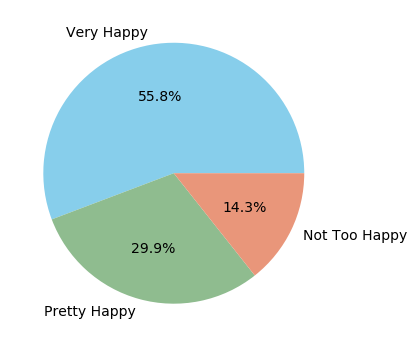

In [18]:
# Breakdown of happiness - pie chart
plt.figure(figsize=(8,6))
happy_labels = ['Very Happy','Pretty Happy','Not Too Happy']
df['happy'].value_counts().plot.pie(labels= happy_labels,
                                    autopct='%1.1f%%',
                                    colors=['skyblue', 'darkseagreen', 'darksalmon'],
                                    textprops={'fontsize': 14})
plt.ylabel('')
plt.show()

As shown in the graphs below, the breakdown of happiness level is fairly consistent in each gender, age groups and region. The composition varies at different income levels, with highest income level having the least percentage of not too happy responses.

For number of TV hours watched, there is no clear pattern, possibly due to more than 30% of observations missing. Yet, it is interesting to see how proprotion of 'not too happy' cateogry peaks at around 9 hours of TV watched per week, but decreases as the number of TV hours increases.

#### By Gender

In [19]:
# happiness breakdown by gender
print(meta_var['sex'])
print(meta_var['happy'])
df['happy'].groupby(by=df['sex']).value_counts()

{1: 'male', 2: 'female'}
{1: 'very happy', 2: 'pretty happy', 3: 'not too happy', 'd': 'DK', 'i': 'IAP', 'n': 'NA'}


sex  happy
1    2.0      583
     1.0      311
     3.0      156
2    2.0      724
     1.0      390
     3.0      180
Name: happy, dtype: int64

In [20]:
# Male Proportions
print('Very Happy', 311/(311+390))
print('Pretty Happy', 583/(583+724))
print('Not Too Happy', 156/(156+180))

Very Happy 0.44365192582025675
Pretty Happy 0.44605967865340473
Not Too Happy 0.4642857142857143


(0, 1800)

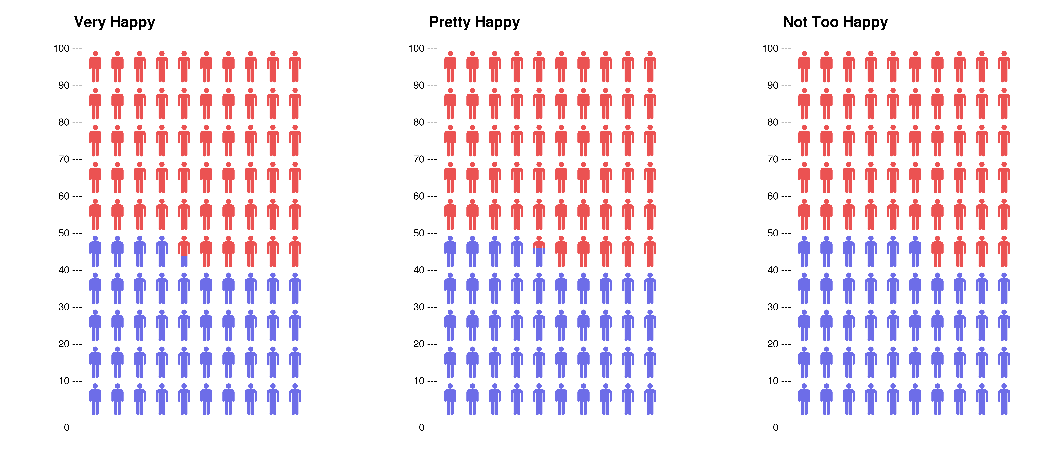

In [21]:
# visualize gender proportions in pictograms
happy1 = mpimg.imread('images/happy1.tiff')
happy2 = mpimg.imread('images/happy2.tiff')
happy3 = mpimg.imread('images/happy3.tiff')

fig, ax = plt.subplots(1,3, figsize=(18,10))
ax[0].imshow(happy1)
ax[0].axis('off')
ax[0].set_xlim([0,1800])

ax[1].imshow(happy2)
ax[1].axis('off')
ax[1].set_xlim([0,1800])

ax[2].imshow(happy3)
ax[2].axis('off')
ax[2].set_xlim([0,1800])

#### By Age Group

In [22]:
# happiness breakdwon by age group
print('Min Age:', df['age'].min())
print('Max Age:', df['age'].max())

Min Age: 18.0
Max Age: 89.0


In [23]:
age_df = df[['age', 'happy']].copy()

ranges_min = [18, 31, 41, 51, 61, 71, 81]
ranges_max = [30, 40, 50, 60, 70, 80, 90]
ranges_labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']

for i in range(7):
    age_df.loc[(age_df['age'] >= ranges_min[i]) & 
               (age_df['age'] <= ranges_max[i]), 'group'] = i
    
age_df['happy'].groupby(by=age_df['group']).value_counts()

group  happy
0.0    2.0      269
       1.0      107
       3.0       72
1.0    2.0      241
       1.0      141
       3.0       58
2.0    2.0      198
       1.0      107
       3.0       55
3.0    2.0      228
       1.0      132
       3.0       59
4.0    2.0      195
       1.0      109
       3.0       54
5.0    2.0      107
       1.0       75
       3.0       24
6.0    2.0       65
       1.0       28
       3.0       13
Name: happy, dtype: int64

In [24]:
age_df['happy'].groupby(by=age_df['group']).value_counts(normalize=True)

group  happy
0.0    2.0      0.600446
       1.0      0.238839
       3.0      0.160714
1.0    2.0      0.547727
       1.0      0.320455
       3.0      0.131818
2.0    2.0      0.550000
       1.0      0.297222
       3.0      0.152778
3.0    2.0      0.544153
       1.0      0.315036
       3.0      0.140811
4.0    2.0      0.544693
       1.0      0.304469
       3.0      0.150838
5.0    2.0      0.519417
       1.0      0.364078
       3.0      0.116505
6.0    2.0      0.613208
       1.0      0.264151
       3.0      0.122642
Name: happy, dtype: float64

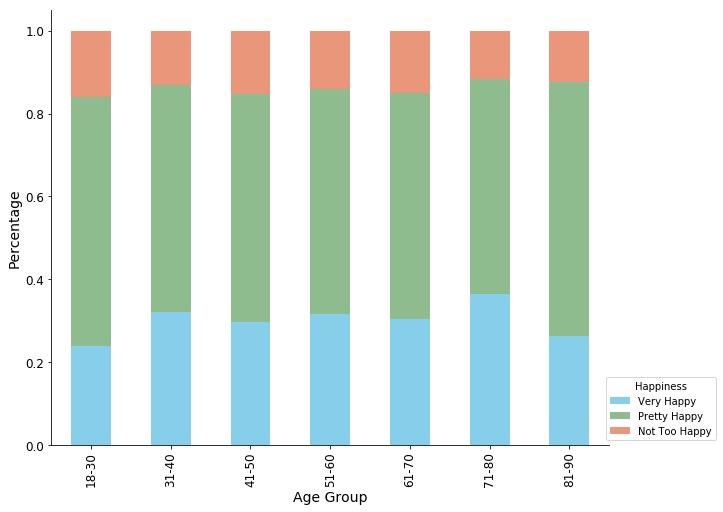

In [25]:
# stacked bar chart -- percentage
ax = age_df['happy'].groupby(by=age_df['group']
                       ).value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Age Group', size=14)
plt.ylabel('Percentage', size=14)
plt.xticks(ticks=range(7), labels=ranges_labels, size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

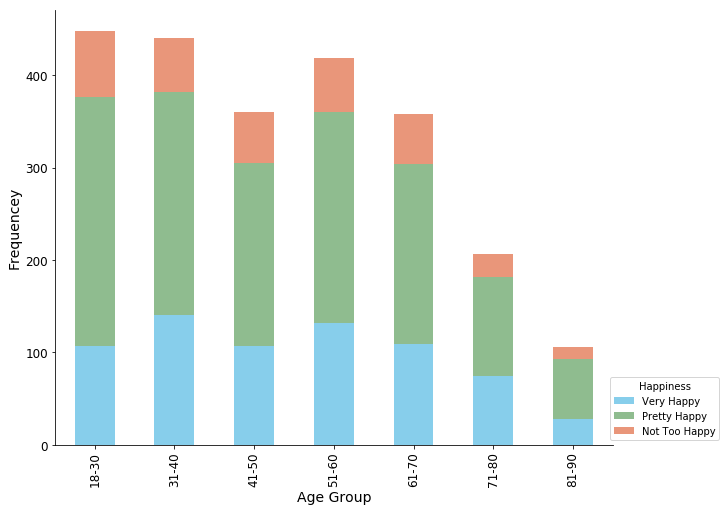

In [26]:
# stacked bar chart -- frequency
ax = age_df['happy'].groupby(by=age_df['group']
                       ).value_counts().unstack().plot(kind='bar', 
                                                        stacked=True,
                                                        color=['skyblue', 
                                                                'darkseagreen', 
                                                                'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Age Group', size=14)
plt.ylabel('Frequencey', size=14)
plt.xticks(ticks=range(7), labels=ranges_labels, size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

In [27]:
age_df['happy'].groupby(by=age_df['group']).size()

group
0.0    448
1.0    441
2.0    361
3.0    419
4.0    360
5.0    206
6.0    106
Name: happy, dtype: int64

#### By Income

In [28]:
meta_var['income16']

{1: 'under $1 000',
 2: '$1 000 to 2 999',
 3: '$3 000 to 3 999',
 4: '$4 000 to 4 999',
 5: '$5 000 to 5 999',
 6: '$6 000 to 6 999',
 7: '$7 000 to 7 999',
 8: '$8 000 to 9 999',
 9: '$10000 to 12499',
 10: '$12500 to 14999',
 11: '$15000 to 17499',
 12: '$17500 to 19999',
 13: '$20000 to 22499',
 14: '$22500 to 24999',
 15: '$25000 to 29999',
 16: '$30000 to 34999',
 17: '$35000 to 39999',
 18: '$40000 to 49999',
 19: '$50000 to 59999',
 20: '$60000 to 74999',
 21: '$75000 to $89999',
 22: '$90000 to $109999',
 23: '$110000 to $129999',
 24: '$130000 to $149999',
 25: '$150000 to $169999',
 26: '$170000 or over',
 27: 'refused',
 98: 'dk',
 99: 'na',
 'i': 'IAP'}

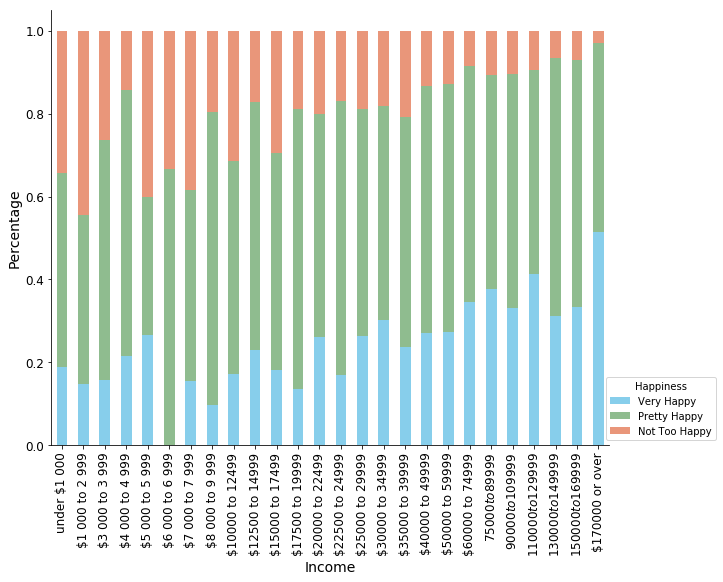

In [29]:
# stacked bar chart -- percentage
income_df = df[['income16', 'happy']].copy()    
ax = income_df['happy'].groupby(by=income_df['income16']).value_counts(normalize=True
                                                                      ).unstack().plot(kind='bar', 
                                                                                    stacked=True,
                                                                                    color=['skyblue', 
                                                                                            'darkseagreen', 
                                                                                            'darksalmon'], 
                                                                                     figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Income', size=14)
plt.ylabel('Percentage', size=14)
plt.xticks(ticks=range(26),labels=[meta_var['income16'][x+1] for x in range(26)], size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

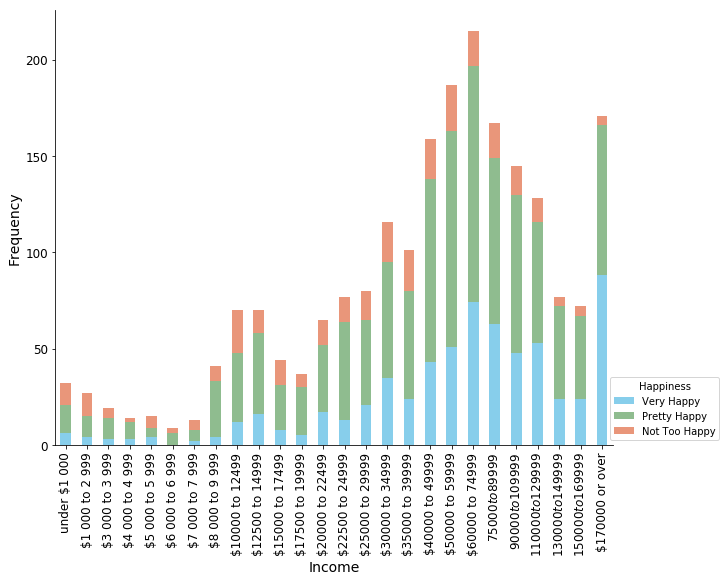

In [30]:
# stacked bar chart -- frequency
income_df = df[['income16', 'happy']].copy()    
ax = income_df['happy'].groupby(by=income_df['income16']).value_counts().unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], 
                                                                    figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Income', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(ticks=range(26),labels=[meta_var['income16'][x+1] for x in range(26)], size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

In [42]:
income_df = pd.DataFrame(df['income16'].value_counts()).reset_index().sort_values(by='index')
income_df.columns = ['group', 'total']

income_df1 = pd.DataFrame(df.loc[df['happy']==1]['income16'].value_counts()
                         ).reset_index().sort_values(by='index')
income_df2 = pd.DataFrame(df.loc[df['happy']==2]['income16'].value_counts()
                         ).reset_index().sort_values(by='index')
income_df3 = pd.DataFrame(df.loc[df['happy']==3]['income16'].value_counts()
                         ).reset_index().sort_values(by='index')

income_df1.columns = ['group', '1']
income_df2.columns = ['group', '2']
income_df3.columns = ['group', '3']

income_comb = pd.merge(income_df3, pd.merge(income_df2, pd.merge(income_df1, income_df
                                                                , how='left', on='group')
                                           , how='left', on='group')
                       , how='left', on='group')
income_comb.head()

,group,3,2,1,total
0,1.0,11,15,6.0,33.0
1,2.0,12,11,4.0,27.0
2,3.0,5,11,3.0,19.0
3,4.0,2,9,3.0,14.0
4,5.0,6,5,4.0,15.0


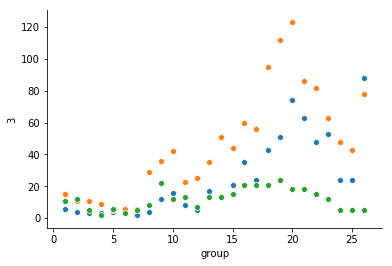

In [43]:
ax = sns.scatterplot('group', '1', data=income_comb, sizes=list(income_comb['1']*100))
ax = sns.scatterplot('group', '2', data=income_comb)
ax = sns.scatterplot('group', '3', data=income_comb)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Text(0, 0.5, 'Family Income In Constant Dollars')

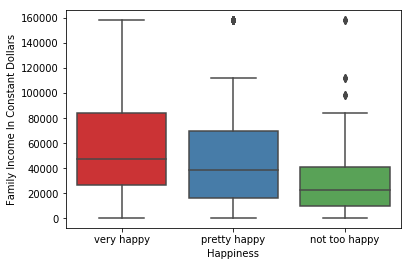

In [44]:
sns.boxplot(x='happy', y='coninc', data=df, palette="Set1")
plt.xticks(ticks=[0,1,2], labels=['very happy', 'pretty happy', 'not too happy'])
plt.xlabel('Happiness')
plt.ylabel(meta_dict['coninc'].title())

#### By Region

In [45]:
meta_var['region']

{1: 'new england',
 2: 'middle atlantic',
 3: 'e. nor. central',
 4: 'w. nor. central',
 5: 'south atlantic',
 6: 'e. sou. central',
 7: 'w. sou. central',
 8: 'mountain',
 9: 'pacific',
 'n': 'NOT ASSIGNED'}

In [46]:
df['region'].value_counts()

5    513
3    388
9    343
7    277
2    232
8    183
6    163
4    125
1    124
Name: region, dtype: int64

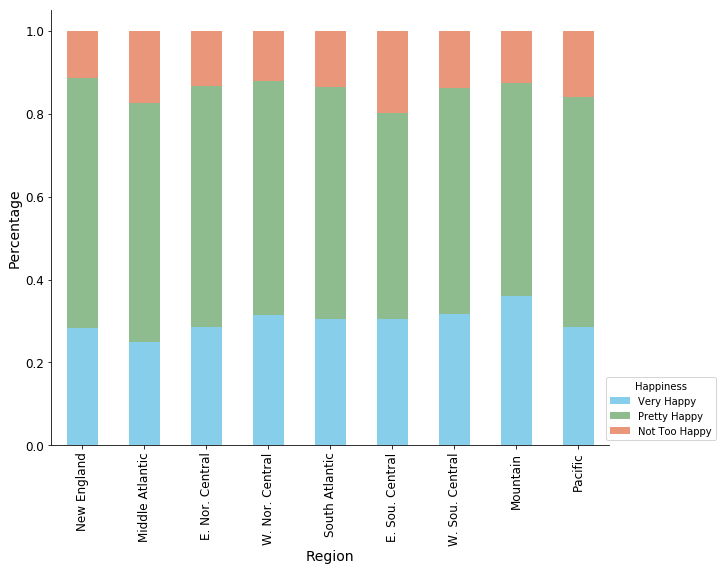

In [47]:
# stacked bar chart -- percentage
region_df = df[['region', 'happy']].copy()    
ax = region_df['happy'].groupby(by=region_df['region']).value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Region', size=14)
plt.ylabel('Percentage', size=14)
plt.xticks(ticks=range(9),labels=[meta_var['region'][x+1].title() for x in range(9)], size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

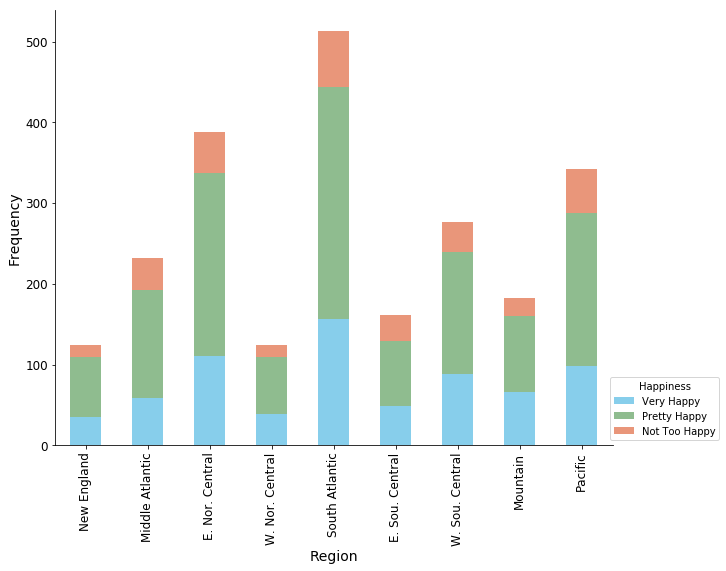

In [48]:
# stacked bar chart -- frequency
region_df = df[['region', 'happy']].copy()    
ax = region_df['happy'].groupby(by=region_df['region']).value_counts().unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Region', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(ticks=range(9),labels=[meta_var['region'][x+1].title() for x in range(9)], size=12)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

In [49]:
reg_size = region_df['happy'].groupby(by=region_df['region']).value_counts().unstack()

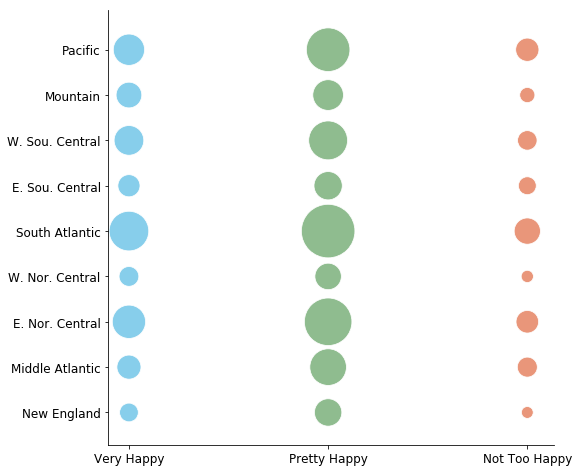

In [50]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot([1]*9, range(9), s=reg_size[1.0]*10, color='skyblue', legend=None)
ax = sns.scatterplot([2]*9, range(9), s=reg_size[2.0]*10, color='darkseagreen', legend=None)
ax = sns.scatterplot([3]*9, range(9), s=reg_size[3.0]*10, color='darksalmon', legend=None)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(ticks=range(1,4), labels=happy_labels, size=12)
plt.yticks(ticks=range(9), labels=[meta_var['region'][x+1].title() for x in range(9)], size=12)


plt.show()

#### TV hours

In [51]:
df['tvhours'].isna().sum()

793

In [37]:
df['tvhours'].isna().sum()/len(df)

0.3377342419080068

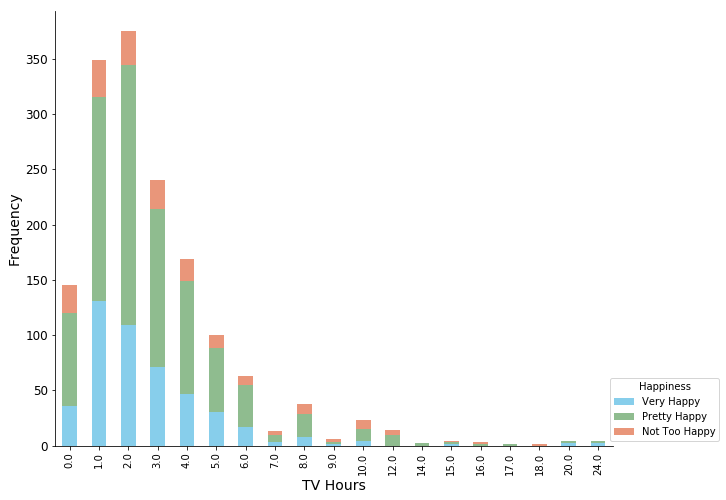

In [52]:
# stacked bar chart -- frequency
tv_df = df[['tvhours', 'happy']].copy()    
ax = tv_df['happy'].groupby(by=tv_df['tvhours']).value_counts().unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('TV Hours', size=14)
plt.ylabel('Frequency', size=14)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

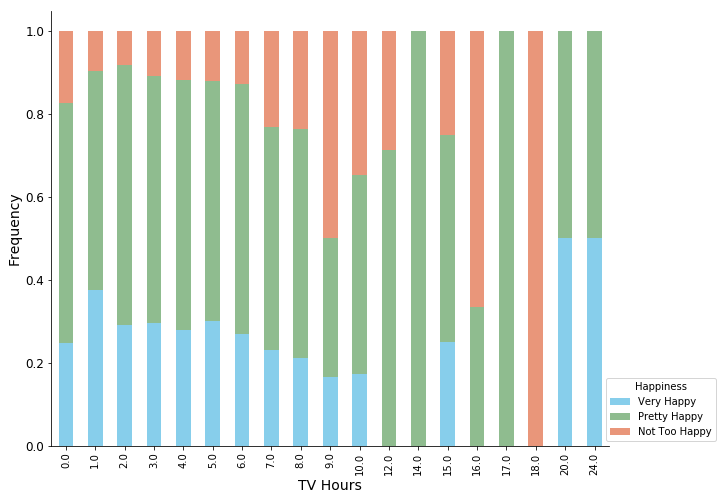

In [53]:
# stacked bar chart -- percentage
tv_df = df[['tvhours', 'happy']].copy()    
ax = tv_df['happy'].groupby(by=tv_df['tvhours']).value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                    stacked=True,
                                                                    color=['skyblue', 
                                                                            'darkseagreen', 
                                                                            'darksalmon'], figsize=(10,8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('TV Hours', size=14)
plt.ylabel('Frequency', size=14)
plt.yticks(size=12)
plt.legend(title='Happiness', labels=happy_labels, 
           loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

### Correlation

Explore how each feature correlates to the 'happy' variable. 

I only considered variables that had less than 1% missing observations. The missing threshold is very strict for the following reasons:
1. The target variable has a class imbalance problem, and the missing observations in the minority classes would worsen the class imbalance problem.
2. Some features have missing observations by construction. More specifically, if a respondent does not have a job, he/she won't be asked the follow-up question on how many hours he/she worked in the past week. Therefore, such features with missing observations are likely to have another features with less missing observations that have already covered the same topic, but with less detailed information.
3. The row dataset has 2,348 features. Considering how most of the variables are categorical variables, the train data set would increase exponentially when the categorical variables are converted to dummy variables. Considering only features with the most comprehensive information would reduce the computation time.

#### Continuous Variables

In [18]:
cont_var_thresh = []

missing_threshold = 0.01
thresh = len(df)*missing_threshold

for col in cont_var:
    if df[col].isnull().sum() <= thresh:
        cont_var_thresh.append(col)

print('# Continous variables : ', len(cont_var))
print('# Continous variables satisfying %.f pct missing threshold: ' % (missing_threshold*100), 
      len(cont_var_thresh))

# Continous variables :  165
# Continous variables satisfying 1 pct missing threshold:  26


In [19]:
# calculate correlation for continuous variables
def calc_corr(missing_threshold=0.1, top_num=20, drop_col=weights):
    '''
    Calcuates correlation on contionuous variables between 'happy' variable
    
    Args:
        missing_threshold : Threshold of missing observations as percentage of total observations.
                            With missing threshold of 0.1, correlation would be calculated for columns
                            that have less than 10% of total observations missing.
        top_num : Number of variables to return with the highest correlation
        drop_col : List of variables to drop
        
    Returns:
        Returns variables with highest correlations as tuple of variable name,
        description, and correlation between 'happy' variable.
    '''
    thresh = len(df)*missing_threshold
    corr_happy = []
    for col in cont_var:
        if col not in drop_col:
            if col not in codes:
                if df[col].isnull().sum() <= thresh:
                    corr = df['happy'].corr(df[col])
                    corr_happy.append((col, meta_dict[col], corr))

    corr_happy_sorted = sorted(corr_happy, key=lambda x: abs(x[2]), reverse=True)
    return corr_happy_sorted[:top_num]

In [20]:
happy_top20_corr = calc_corr(missing_threshold=0.01)
for i in happy_top20_corr:
    print(i)

('ratepain', "in the past 7 days, r's average pain", 0.18250877785537895)
('earnrs', 'how many in family earned money', -0.10242882490860239)
('educ', 'highest year of school completed', -0.09350703947951497)
('hompop', 'number of persons in household', -0.08246174972733428)
('childs', 'number of children', -0.07432636620410472)
('adults', 'household members 18 yrs and older', -0.07019462485476766)
('dateintv', 'date of interview', -0.06748608991632771)
('intage', 'age of interviewer', -0.06233969479379164)
('version', 'version of questionnaire', 0.053312629745818955)
('size', 'size of place in 1000s', 0.05097144777556137)
('cohort', 'year of birth', 0.043350936410314685)
('age', 'age of respondent', -0.04335093641031466)
('intyrs', 'years of service as an interviewer at norc', -0.04060289676566035)
('lngthinv', 'how long was interview', 0.038293749898292824)
('intid', 'interviewer id', -0.02487561165250017)
('vpsu', 'variance primary sampling unit', 0.024032547100484986)
('sibs', 'num

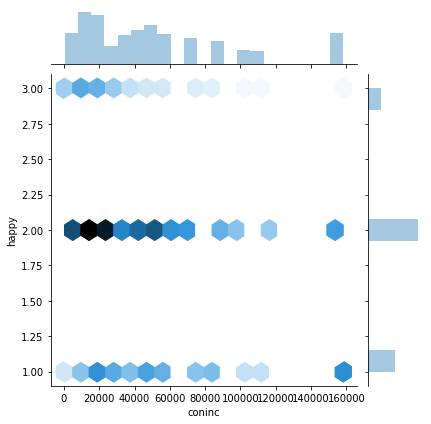

In [21]:
sns.jointplot("coninc", "happy", data=df, kind='hex')

In [22]:
for x in happy_top20_corr:
    data_dict(x[0])

----------------------
RATEPAIN
----------------------
Description:        in the past 7 days, r's average pain
Observations:       2328                
Missing Values:     20                  

Responses:
0.0     0.244416
1.0     0.151632
2.0     0.134021
3.0     0.126718
5.0     0.087629
4.0     0.082904
6.0     0.061426
7.0     0.060137
8.0     0.029210
9.0     0.012027
10.0    0.009880
Name: ratepain, dtype: float64
----------------------
EARNRS
----------------------
Description:        how many in family earned money
Observations:       2336                
Missing Values:     12                  

Responses:
1.0    0.381421
2.0    0.326199
0.0    0.181079
3.0    0.077483
4.0    0.027825
5.0    0.004281
7.0    0.000856
8.0    0.000428
6.0    0.000428
Name: earnrs, dtype: float64
----------------------
EDUC
----------------------
Description:        highest year of school completed
Observations:       2345                
Missing Values:     3                   

Responses:
12.0  

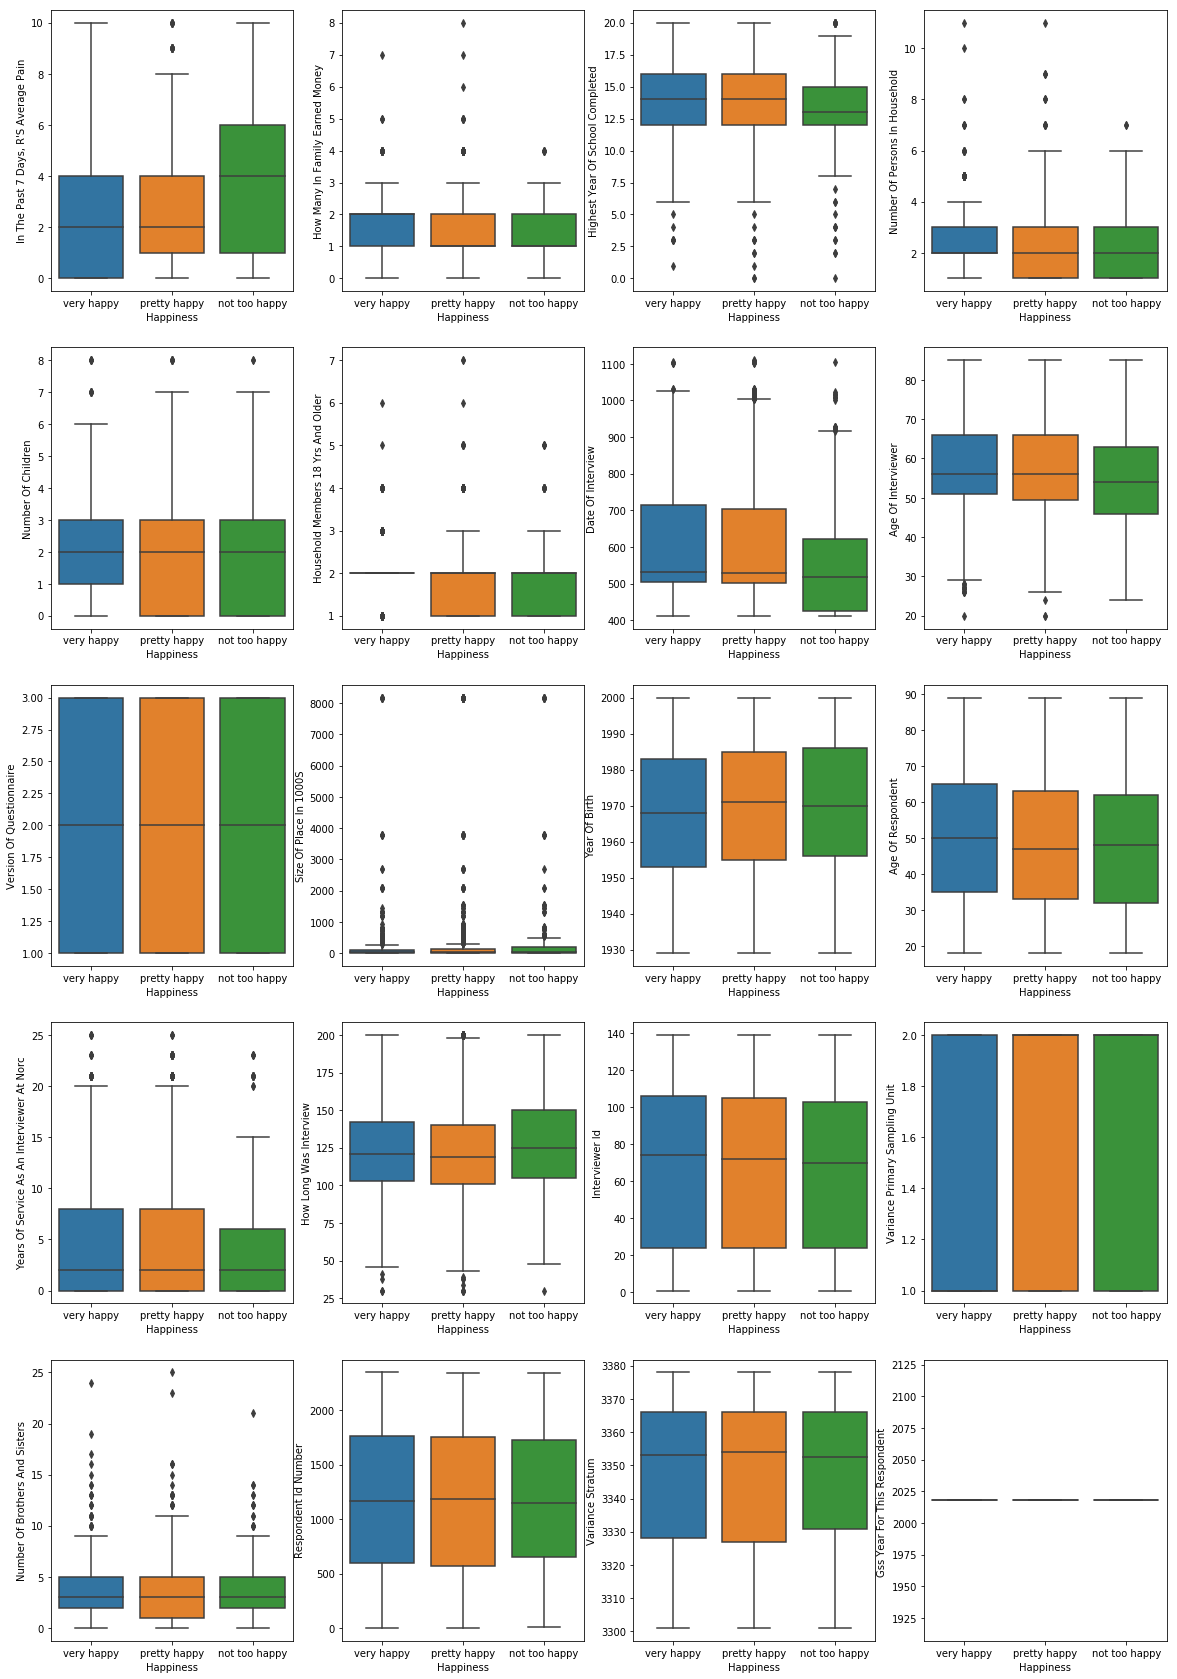

In [42]:
# box plot between 'happy' and top 20 continuous variables with highest correlation
fig, ax = plt.subplots(5, 4, figsize=(20,30))

for indx, i in enumerate(happy_top20_corr):
    plt.subplot(5,4,(indx+1))
    sns.boxplot(x='happy', y=i[0], data=df)
    plt.xticks(ticks=[0,1,2], labels=['very happy', 'pretty happy', 'not too happy'])
    plt.xlabel('Happiness')
    plt.ylabel(meta_dict[i[0]].title())
    
plt.show()

#### Categorical Variables

In [23]:
cat_var_thresh = []

missing_threshold = 0.01
thresh = len(df)*missing_threshold

for col in cat_var:
    if df[col].isnull().sum() <= thresh:
        cat_var_thresh.append(col)

for col in codes:
    if df[col].isnull().sum() <= thresh:
        cat_var_thresh.append(col)

print('# Categorical variables : ', len(cat_var))
print('# Categorical variables satisfying %.f pct missing threshold: ' % (missing_threshold*100), 
      len(cat_var_thresh))

# Categorical variables :  899
# Categorical variables satisfying 1 pct missing threshold:  83


In [49]:
# Calculate correlation ratio of the categorical variables
# weighted variance of the mean of each category divided by the variance of all samples
# i.e. Given a continuous number, how well can you know to which category it belongs to?
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def correlation_ratio(categories, target):
    '''
    Calcuates correlation ratio on categorical variables.
    
    Args:
       categories: categorical variable to calculate correlation ratio
       target: target variable
        
    Returns:
        Returns correlation ratio between a categorical variable and a target variable.
    '''
    
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = target[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.nanmean(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(target,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


In [50]:
# Calculate correlation ratio of the categorical variables

def calc_corr_ratio(missing_threshold=0.1, top_num=20, drop_col=weights):
    '''

    Calcuates correlation on categorical variables between 'happy' variable
    
    Args:
        missing_threshold : Threshold of missing observations as percentage of total observations.
                            With missing threshold of 0.1, correlation would be calculated for columns
                            that have less than 10% of total observations missing.
        top_num : Number of variables to return with the highest correlation
        drop_col : List of variables to drop
        
    Returns:
        Returns variables with highest correlations as tuple of variable name,
        description, and correlation between 'happy' variable.
   
    '''
    thresh = len(df)*missing_threshold
    corr_happy = []
    for col in cat_var:
        if col not in drop_col:
            if col != 'happy':
                if df[col].isnull().sum() <= thresh:
                    corr = correlation_ratio(df[col], df['happy'])
                    corr_happy.append((col, meta_dict[col], corr))

    for col in codes:
        if col not in drop_col:
            if df[col].isnull().sum() <= thresh:
                corr = correlation_ratio(df[col], df['happy'])
                corr_happy.append((col, meta_dict[col], corr))

    corr_happy_sorted = sorted(corr_happy, key=lambda x: abs(x[2]), reverse=True)
    return corr_happy_sorted[:top_num]

In [51]:
happy_top20_corr_ratio = calc_corr_ratio(missing_threshold=0.01)
for i in happy_top20_corr_ratio:
    print(i)

('quallife', "r's quality of life", 0.41078288287104914)
('satsoc', "r's satisfaction with social activities and relationships", 0.4028116499360288)
('hlthmntl', "r's mental health, mood, and ability to think", 0.3610256319495759)
('marcohab', 'cohabitation status', 0.3242359440552119)
('emoprobs', 'in the past 7 days, how often r has been bothered by emotional problems', 0.32310529570474905)
('satfin', 'satisfaction with financial situation', 0.31883453333170847)
('hhtype', 'household type', 0.31388539003204907)
('hlthphys', "r's physical health", 0.2928169187009263)
('marital', 'marital status', 0.29147968616926373)
('healthissp', 'merged healthissp_d and healthissp_e', 0.2890860491783513)
('actssoc', 'how well r carries out usual social activities', 0.28336363418446053)
('hhtype1', 'household type (condensed)', 0.26897779052232884)
('sampcode', 'sampling error code', 0.20378023581475466)
('finalter', 'change in financial situation', 0.19081474997495163)
('rplace', "r's relationship 

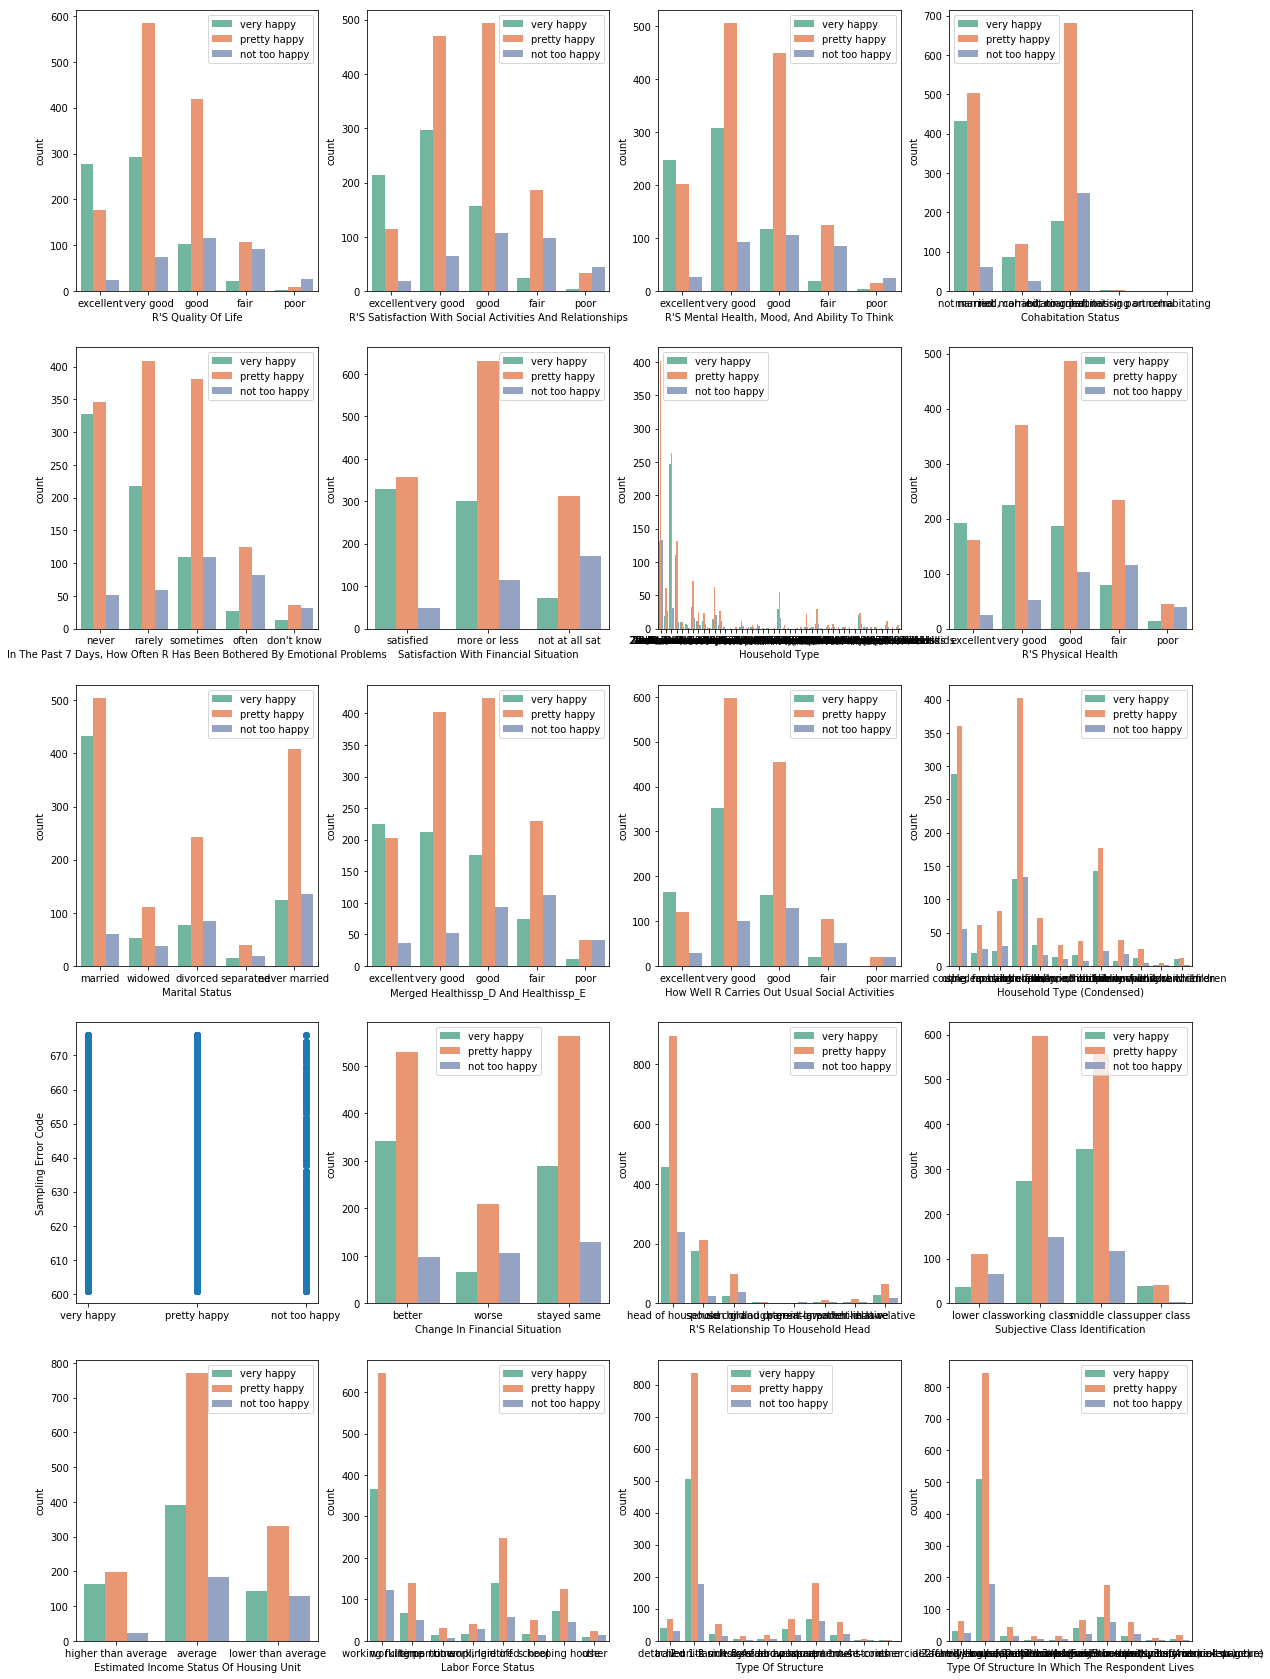

In [35]:
# barplot between 'happy' and top 20 categorical variables with highest correlation
# for code variables, graph scatter plot for simplicity
fig, ax = plt.subplots(5, 4, figsize=(20,30))

for indx, i in enumerate(happy_top20_corr_ratio):
    if i[0] in codes:
        plt.subplot(5,4, indx+1)
        plt.scatter(df['happy'], df[i[0]])
        plt.ylabel(meta_dict[i[0]].title())
        plt.xticks([1,2,3], ['very happy', 'pretty happy', 'not too happy'])
    
    else:
        plt.subplot(5,4, indx+1)
        sns.countplot(df[i[0]], hue=df['happy'], palette='Set2')
        if i[0] != 'rank':
            if i[0] == 'emoprobs':
                plt.xticks(ticks=range(len(df[i[0]].dropna().unique())),
                           labels=['never', 'rarely', 'sometimes', 'often', "don't know"])

            else:
                plt.xticks(ticks=range(len(df[i[0]].dropna().unique())),
                           labels=[meta_var[i[0]][x] for x in sorted(list(df[i[0]].dropna().unique()))])
        plt.xlabel(meta_dict[i[0]].title())
        plt.legend(['very happy', 'pretty happy', 'not too happy'])
        
plt.show()

## Feature Selection

Select features that have high correlation with the happiness variable.

In [52]:
print('------------------') 
print('Continuous variables:')
print('------------------') 
for i in happy_top20_corr:
    print(i)
    
print('------------------') 
print('Categorical variables:')
print('------------------') 
for i in happy_top20_corr_ratio:
    print(i)

------------------
Continuous variables:
------------------
('ratepain', "in the past 7 days, r's average pain", 0.18250877785537895)
('earnrs', 'how many in family earned money', -0.10242882490860239)
('educ', 'highest year of school completed', -0.09350703947951497)
('hompop', 'number of persons in household', -0.08246174972733428)
('childs', 'number of children', -0.07432636620410472)
('adults', 'household members 18 yrs and older', -0.07019462485476766)
('dateintv', 'date of interview', -0.06748608991632771)
('intage', 'age of interviewer', -0.06233969479379164)
('version', 'version of questionnaire', 0.053312629745818955)
('size', 'size of place in 1000s', 0.05097144777556137)
('cohort', 'year of birth', 0.043350936410314685)
('age', 'age of respondent', -0.04335093641031466)
('intyrs', 'years of service as an interviewer at norc', -0.04060289676566035)
('lngthinv', 'how long was interview', 0.038293749898292824)
('intid', 'interviewer id', -0.02487561165250017)
('vpsu', 'variance

In [53]:
# Select features to be added in the model
# Features not directly related to the respondent should be removed
# e.g. date of interview, interviewer's age, etc.
features = []

for col in happy_top20_corr:
    features.append(col[0])
for col in happy_top20_corr_ratio:
    features.append(col[0])    

clean = ['dateintv', 'version', 'intyrs', 'intage', 'lngthinv', 'intid',
         'vpsu', 'id', 'vstrat', 'year'] 

for x in clean:
    if x in features:
        features.remove(x)

print(len(features))
print(features)

30
['ratepain', 'earnrs', 'educ', 'hompop', 'childs', 'adults', 'size', 'cohort', 'age', 'sibs', 'quallife', 'satsoc', 'hlthmntl', 'marcohab', 'emoprobs', 'satfin', 'hhtype', 'hlthphys', 'marital', 'healthissp', 'actssoc', 'hhtype1', 'sampcode', 'finalter', 'rplace', 'class', 'incuspop', 'wrkstat', 'dwelling', 'dwellpre']


In [54]:
# Additional variables of interest
# Chosen manually after review of the data dictionary
variables = ['wrkstat', 'hrs1', 'hrs2', 'evwork', 'wrkslf', 
        'wrkgovt', 'occ10', 'prestg10', 'indus10', 'marital', 
        'martype', 'marcohab', 'divorce', 'widowed', 'spwrksta', 
        'sphrs1', 'sphrs2', 'spevwork', 'spwrkslf', 'spocc10',
        'sppres10', 'spind10', 'cowrksta', 'cohrs1', 'cohrs2',
        'coevwork', 'coocc10', 'copres10', 'coind10', 'cowrkslf',
        'sibs' , 'childs', 'age','agekdbrn','degree',
        'spdeg','codeg','major1','sex','race',
        'res16', 'reg16','incom16', 'born','parborn',
        'hompop', 'babies','preteen','teens','adults',
        'income','rincome','region','xnorcsiz','partyid',
        'polviews','relig','hapmar','hapcohab',
        'health','life','helpful','fair','trust',
        'socrel','socommun','socfrend','socbar','weekswrk', 
        'partfull','joblose','jobfind','satjob','richwork',
        'class','rank','satfin','finrela','parsol',
        'chldidel','tvhours'
       ]

In [55]:
# Among the additional variables, drop the variables not reaching the null observation threshold.
missing_threshold = 0.01

features_add = []
for var in variables:
    thresh = len(df)*missing_threshold
    if df[var].isnull().sum() <= thresh:
        if var not in features:
            features_add.append(var)
            print(var,": ", meta_dict[var])

degree :  r's highest degree
sex :  respondents sex
race :  race of respondent
res16 :  type of place lived in when 16 yrs old
reg16 :  region of residence, age 16
born :  was r born in this country
parborn :  were r's parents born in this country
region :  region of interview
xnorcsiz :  expanded norc size code
relig :  r's religious preference


In [33]:
# for x in features_add:
#     data_dict(x)

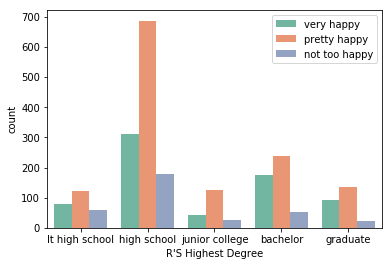

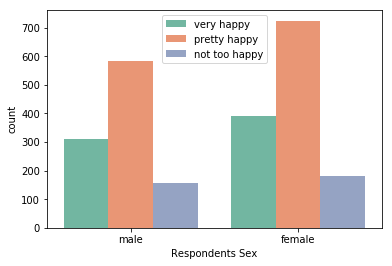

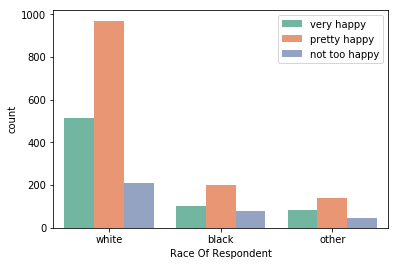

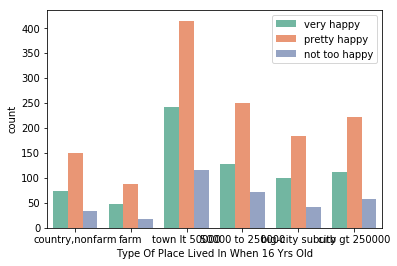

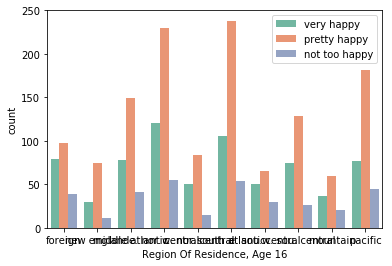

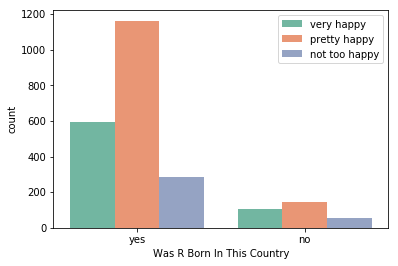

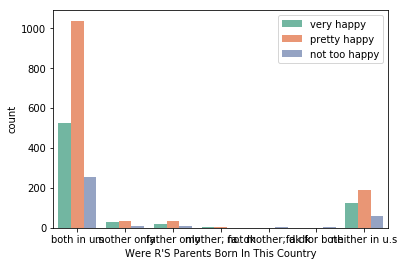

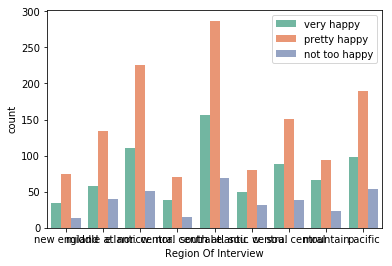

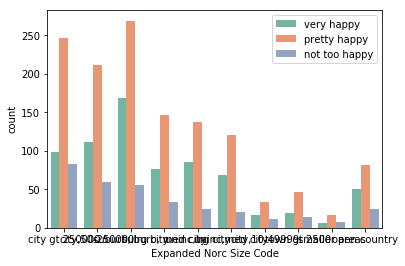

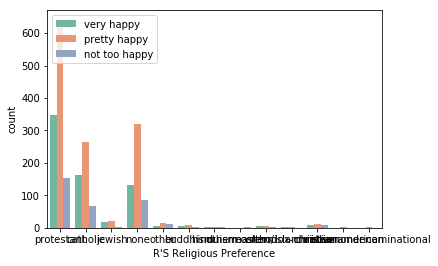

In [69]:
# fig, ax = plt.subplots(11, 2, figsize=(10,30))

for indx, i in enumerate(features_add):
    
    if i in cont_var:
        sns.boxplot(x='happy', y=i, data=df)
        plt.xticks(ticks=[0,1,2], labels=['very happy', 'pretty happy', 'not too happy'])
        plt.xlabel('Happiness')
        plt.ylabel(meta_dict[i].title())
        plt.show()
        
    elif i in cat_var:
        sns.countplot(df[i], hue=df['happy'], palette='Set2')
        plt.xticks(ticks=range(len(df[i].dropna().unique())),
        labels=[meta_var[i][x] for x in sorted(list(df[i].dropna().unique()))])
        plt.xlabel(meta_dict[i].title())
        plt.legend(['very happy', 'pretty happy', 'not too happy'])
        plt.show()

In [56]:
# Clean df for models
df_cln = df[features+features_add+['happy']].dropna()
print(len(df_cln))
df_cln.head()

2232


,ratepain,earnrs,educ,hompop,childs,adults,size,cohort,age,sibs,...,sex,race,res16,reg16,born,parborn,region,xnorcsiz,relig,happy
0,1.0,1.0,14.0,5,0.0,5.0,14,1975.0,43.0,4.0,...,1,1,3,2,1.0,0.0,1,6,11.0,2.0
1,7.0,1.0,10.0,2,3.0,2.0,14,1944.0,74.0,4.0,...,2,1,4,2,1.0,1.0,1,6,2.0,1.0
2,2.0,2.0,16.0,4,2.0,2.0,14,1976.0,42.0,2.0,...,1,1,5,2,1.0,2.0,1,6,4.0,1.0
3,2.0,2.0,16.0,2,2.0,2.0,14,1955.0,63.0,3.0,...,2,1,3,2,1.0,0.0,1,6,1.0,1.0
4,0.0,1.0,18.0,2,0.0,2.0,14,1947.0,71.0,3.0,...,1,2,5,2,1.0,2.0,1,6,2.0,2.0


Total of 40 features were selected.

## Prepare dataset for models

From the previous section, I selected total of 40 selections for machine learning based on correlation between the target variable. Potentially important features might have been dropped during this process. Therefore, I would train models on all features (still satisfying the missing threshold) and inspect the features importances as a sanity check.

In addition, the target variable suffers from class imbalance problem, and I'm more interested in the model's performance in the minority classes ('very happy' vs. 'not too happy'). Therefore, I will also train models focusing on the two minority classes.

#### All features

In [72]:
# drop the variables not reaching the null observation threshold
missing_threshold = 0.01

features_all = []
for col in df.columns:
    thresh = len(df)*missing_threshold
    if df[col].isnull().sum() <= thresh:
        features_all.append(col)

features_all.remove('happy') #remove target variable

len(features_all)

105

In [73]:
df_all_cln = df[features_all+['happy']].dropna()
print(len(df_all_cln))

2137


In [74]:
# sanity check there are 'not too happy' observations in the dataset
print(len(df_all_cln[df_all_cln['happy']==3]))
df_all_cln[df_all_cln['happy']==3].head()

296


,actssoc,adults,age,attend,ballot,born,childs,class,cohort,comprend,...,whoelse4,whoelse5,whoelse6,wrkstat,wtss,wtssall,wtssnr,xnorcsiz,year,happy
5,3.0,2.0,67.0,4.0,1,1.0,2.0,2.0,1951.0,1.0,...,2.0,2.0,1.0,5.0,0.942997,0.942997,1.101412,6,2018,3.0
8,3.0,1.0,62.0,0.0,2,1.0,4.0,1.0,1956.0,1.0,...,2.0,2.0,2.0,1.0,0.471499,0.471499,0.550706,2,2018,3.0
12,3.0,1.0,61.0,0.0,1,1.0,2.0,2.0,1957.0,1.0,...,2.0,2.0,1.0,5.0,0.471499,0.471499,0.550706,4,2018,3.0
16,3.0,2.0,55.0,1.0,2,1.0,0.0,2.0,1963.0,1.0,...,2.0,2.0,1.0,4.0,0.942997,0.942997,1.101412,3,2018,3.0
19,3.0,4.0,30.0,5.0,2,2.0,0.0,3.0,1988.0,1.0,...,2.0,2.0,1.0,1.0,4.717936,4.717936,5.510508,3,2018,3.0


In [75]:
# features that are categorical variables
features_all_cat = []
for x in features_all:
    if x in cat_var:
        features_all_cat.append(x)
    elif x in codes:
        features_all_cat.append(x)

len(features_all_cat)

80

In [76]:
# One-hot encode the categorical features
one_hot_df_all = pd.get_dummies(df_all_cln, columns=features_all_cat)

target_all = one_hot_df_all['happy']
one_hot_df_all.drop('happy', axis=1, inplace=True)

print(one_hot_df_all.columns)
one_hot_df_all.head()

Index(['adults', 'age', 'childs', 'cohort', 'dateintv', 'earnrs', 'educ',
       'formwt', 'hompop', 'id',
       ...
       'xnorcsiz_1', 'xnorcsiz_2', 'xnorcsiz_3', 'xnorcsiz_4', 'xnorcsiz_5',
       'xnorcsiz_6', 'xnorcsiz_7', 'xnorcsiz_8', 'xnorcsiz_9', 'xnorcsiz_10'],
      dtype='object', length=512)


,adults,age,childs,cohort,dateintv,earnrs,educ,formwt,hompop,id,...,xnorcsiz_1,xnorcsiz_2,xnorcsiz_3,xnorcsiz_4,xnorcsiz_5,xnorcsiz_6,xnorcsiz_7,xnorcsiz_8,xnorcsiz_9,xnorcsiz_10
0,5.0,43.0,0.0,1975.0,907,1.0,14.0,1,5,1,...,0,0,0,0,0,1,0,0,0,0
1,2.0,74.0,3.0,1944.0,426,1.0,10.0,1,2,2,...,0,0,0,0,0,1,0,0,0,0
2,2.0,42.0,2.0,1976.0,910,2.0,16.0,1,4,3,...,0,0,0,0,0,1,0,0,0,0
3,2.0,63.0,2.0,1955.0,425,2.0,16.0,1,2,4,...,0,0,0,0,0,1,0,0,0,0
4,2.0,71.0,0.0,1947.0,718,1.0,18.0,1,2,5,...,0,0,0,0,0,1,0,0,0,0


In [77]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(one_hot_df_all, target_all, test_size=0.2,
                                                    random_state=123)

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
X_train_scaled_all = scaler.fit_transform(X_train_all)
X_test_scaled_all = scaler.transform(X_test_all)

# Use the SMOTE class from the imblearn package in order to improve 
# the model's performance on the minority class.
# SMOTE should only be applied to training sets.

smote = SMOTE()
X_train_resampled_all, y_train_resampled_all = smote.fit_sample(X_train_scaled_all, y_train_all) 

# Original class distribution
print('Original class distribution: \n')
print(target_all.value_counts())

# Synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled_all).value_counts()) 

Original class distribution: 

2.0    1197
1.0     644
3.0     296
Name: happy, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1.0    968
2.0    968
3.0    968
Name: happy, dtype: int64


#### All features for extreme categories

In [78]:
# number of 'not too happy' or 'very happy' observations in the df_all_cln
df_bi_cln = df_all_cln[df_all_cln['happy'] != 2]
len(df_bi_cln)

940

In [79]:
# One-hot encode the categorical features
one_hot_df_bi = pd.get_dummies(df_bi_cln, columns=features_all_cat)

target_bi = one_hot_df_bi['happy']
one_hot_df_bi.drop('happy', axis=1, inplace=True)

print(one_hot_df_bi.columns)
one_hot_df_bi.head()

Index(['adults', 'age', 'childs', 'cohort', 'dateintv', 'earnrs', 'educ',
       'formwt', 'hompop', 'id',
       ...
       'xnorcsiz_1', 'xnorcsiz_2', 'xnorcsiz_3', 'xnorcsiz_4', 'xnorcsiz_5',
       'xnorcsiz_6', 'xnorcsiz_7', 'xnorcsiz_8', 'xnorcsiz_9', 'xnorcsiz_10'],
      dtype='object', length=493)


,adults,age,childs,cohort,dateintv,earnrs,educ,formwt,hompop,id,...,xnorcsiz_1,xnorcsiz_2,xnorcsiz_3,xnorcsiz_4,xnorcsiz_5,xnorcsiz_6,xnorcsiz_7,xnorcsiz_8,xnorcsiz_9,xnorcsiz_10
1,2.0,74.0,3.0,1944.0,426,1.0,10.0,1,2,2,...,0,0,0,0,0,1,0,0,0,0
2,2.0,42.0,2.0,1976.0,910,2.0,16.0,1,4,3,...,0,0,0,0,0,1,0,0,0,0
3,2.0,63.0,2.0,1955.0,425,2.0,16.0,1,2,4,...,0,0,0,0,0,1,0,0,0,0
5,2.0,67.0,2.0,1951.0,521,1.0,16.0,1,2,6,...,0,0,0,0,0,1,0,0,0,0
8,1.0,62.0,4.0,1956.0,505,1.0,8.0,1,1,9,...,0,1,0,0,0,0,0,0,0,0


In [80]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(one_hot_df_bi, target_bi, test_size=0.2,
                                                    random_state=123)

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
X_train_scaled_bi = scaler.fit_transform(X_train_bi)
X_test_scaled_bi = scaler.transform(X_test_bi)

smote = SMOTE()
X_train_resampled_bi, y_train_resampled_bi = smote.fit_sample(X_train_scaled_bi, y_train_bi) 

# Original class distribution
print('Original class distribution: \n')
print(target_bi.value_counts())

# Synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled_bi).value_counts()) 

Original class distribution: 

1.0    644
3.0    296
Name: happy, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

3.0    529
1.0    529
Name: happy, dtype: int64


## Machine Learning

### **Helpful Functions**

In [37]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds,average=None)))
    print("Recall Score: {}".format(recall_score(labels, preds, average=None)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average=None)))

In [38]:
def plot_feature_importances(df, model, num=30, return_list=False):
    '''
    Args:
       df : Underlying datafarame of the model 
       model : Model to extract feature importances from
       num : Number of features to plot
       return_list : If true, returns the list of n features
    
    Returns:
        Plots a bar graph of feature importances of n features, in 
        in descending order of feature importances
        If return_list = Ture, returns the list of sorted n features.
        
    '''
    tree_feat_imp = dict(zip(df.columns, model.feature_importances_))
    data = sorted(tree_feat_imp.items(), key=lambda x: x[1], reverse=True)[:num]
    
    data_labels= []
    for i in data:
        splited = i[0].split('_')
        if len(splited) == 1:
            data_labels.append(meta_dict[splited[0]])
        else:
            data_labels.append('{}_{}'.format(meta_dict[splited[0]], 
                                              meta_var[splited[0]][float(splited[1])]))


    
    plt.barh([x[0] for x in data], [x[1] for x in data], align='center', color='cadetblue') 
    plt.xlabel("Feature importance", size=14)
    plt.yticks(ticks=range(num),labels=data_labels, size=12)
    
    if return_list:
        return data

In [39]:
def plot_cm(target, labels, name, target_classes=3):
    '''
    Args:
       target : True labels of the target variable 
       labels : Predicted labels of the target variable
       name : String; Name of the model to be specified as the title of the plot
       target_classes : Number of classes in the target variable 
    
    Returns:
        Plots confusion metrix.
        
    '''
    cm = confusion_matrix(target, labels) 
    
    # Transform to df for easier plotting
    if target_classes == 3:
        cm_df = pd.DataFrame(cm,
                             index = ['Very Happy','Pretty Happy','Not Too Happy'], 
                             columns = ['Very Happy','Pretty Happy','Not Too Happy'])
    else:
        cm_df = pd.DataFrame(cm,
                 index = ['Very Happy','Not Too Happy'], 
                 columns = ['Very Happy','Not Too Happy'])
        
    sns.heatmap(cm_df, annot=True, cmap='GnBu', vmax=60, annot_kws={"size": 14}, fmt='.3g')
    plt.title('{} \nAccuracy:{} \nWeighted F1 Score:{}'.format(name, 
                                        np.round(accuracy_score(target, labels),3),
                                        np.round(f1_score(target, labels, average='weighted'),3)),
               
             size=17)
    
    plt.ylabel('True label', size=15)
    plt.yticks(rotation=30) 
    plt.xlabel('Predicted label', size=15)


### Vanilla models

In [91]:
pipeline_names = ['Decision Tree','Random Forest', 'Adaboost', 'Gradient Boosting', 'XGBoost']

#### All features

In [92]:
# oversampled data, all features
pipe_tree_all = Pipeline([('clf', DecisionTreeClassifier(random_state=123))])
pipe_forest_all = Pipeline([('clf', RandomForestClassifier(random_state=123))])
pipe_adaboost_all = Pipeline([('clf', AdaBoostClassifier(random_state=123))])
pipe_gbt_all = Pipeline([('clf', GradientBoostingClassifier(random_state=123))])
pipe_xgb_all = Pipeline([('clf', XGB.XGBClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines_all = [pipe_tree_all, pipe_forest_all, pipe_adaboost_all, pipe_gbt_all, pipe_xgb_all]

# Loop to fit each of the three pipelines

# for pipe in pipelines_all:
#     print(pipe)
#     pipe.fit(X_train_resampled_all, y_train_resampled_all)

Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
        

In [93]:
# save the model to disk

# filename = 'smote_vanilla_all_features_pipelines.sav'
# pickle.dump(pipelines_all, open(filename, 'wb'))
# pipelines_all = pickle.load(open(filename, 'rb'))

In [211]:
# Compare accuracies & f1 score
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
for index, val in enumerate(pipelines_all):
    print('%s : %.3f' % (pipeline_names[index], val.score(X_test_scaled_all, y_test_all)))
    
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
for index, val in enumerate(pipelines_all):
    print('%s : %.3f' % (pipeline_names[index],
                         f1_score(y_test_all, val.predict(X_test_scaled_all), average='weighted')))

----------------------------------------
Accuracy
----------------------------------------
Decision Tree : 0.530
Random Forest : 0.614
Adaboost : 0.577
Gradient Boosting : 0.610
XGBoost : 0.612

----------------------------------------
Weighted F1 Score
----------------------------------------
Decision Tree : 0.531
Random Forest : 0.574
Adaboost : 0.578
Gradient Boosting : 0.596
XGBoost : 0.591


Gradient Boosting is the best performing vanilla model for all features.

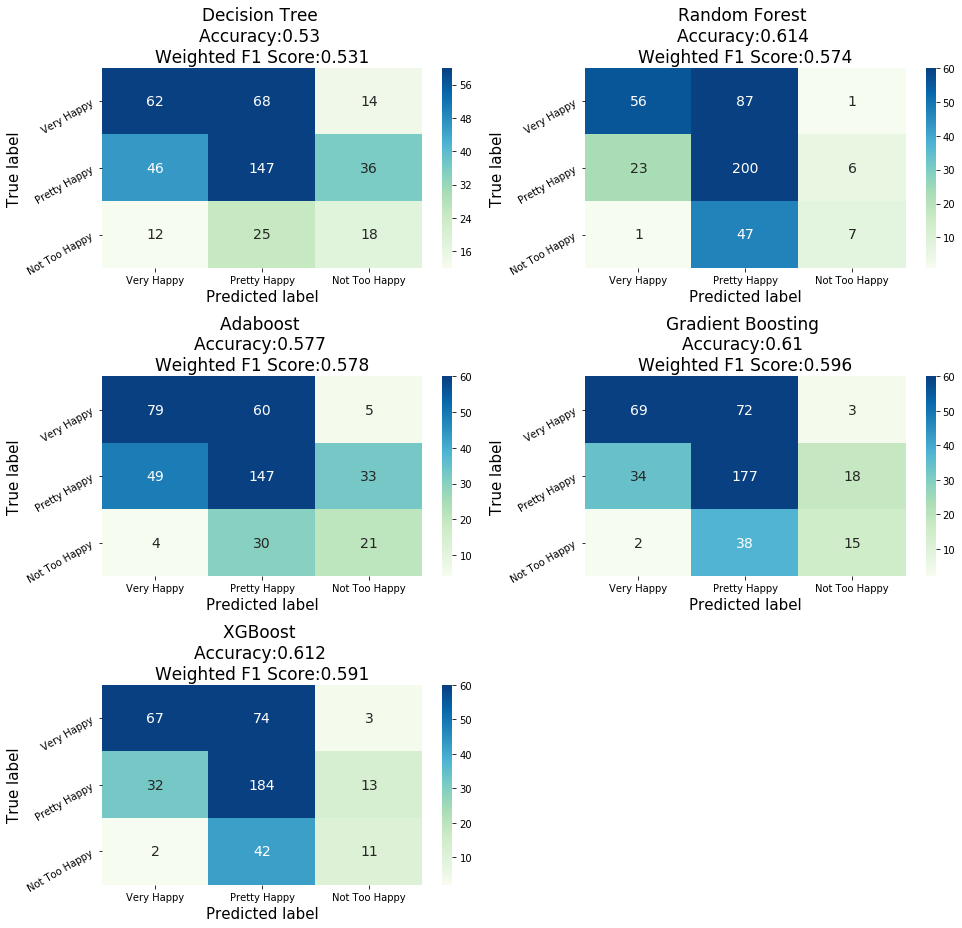

In [205]:
# confusion matrix
fig, ax = plt.subplots(3, 2, figsize=(14,13))
for index, val in enumerate(pipelines_all):
    plt.subplot(3,2,index+1)
    plot_cm(y_test_all, val.predict(X_test_scaled_all), pipeline_names[index])
    
fig.tight_layout()
fig.delaxes(ax[-1,-1])
plt.show()

In [292]:
for index, val in enumerate(pipelines_all):
    print('----------------------------------------')
    print(pipeline_names[index])
    print('----------------------------------------')
    print(classification_report(y_test_all, val.predict(X_test_scaled_all)))

----------------------------------------
Decision Tree
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.52      0.43      0.47       144
         2.0       0.61      0.64      0.63       229
         3.0       0.26      0.33      0.29        55

    accuracy                           0.53       428
   macro avg       0.46      0.47      0.46       428
weighted avg       0.54      0.53      0.53       428

----------------------------------------
Random Forest
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.70      0.39      0.50       144
         2.0       0.60      0.87      0.71       229
         3.0       0.50      0.13      0.20        55

    accuracy                           0.61       428
   macro avg       0.60      0.46      0.47       428
weighted avg       0.62      0.61      0.57       428

----------------------------------------
Adabo

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


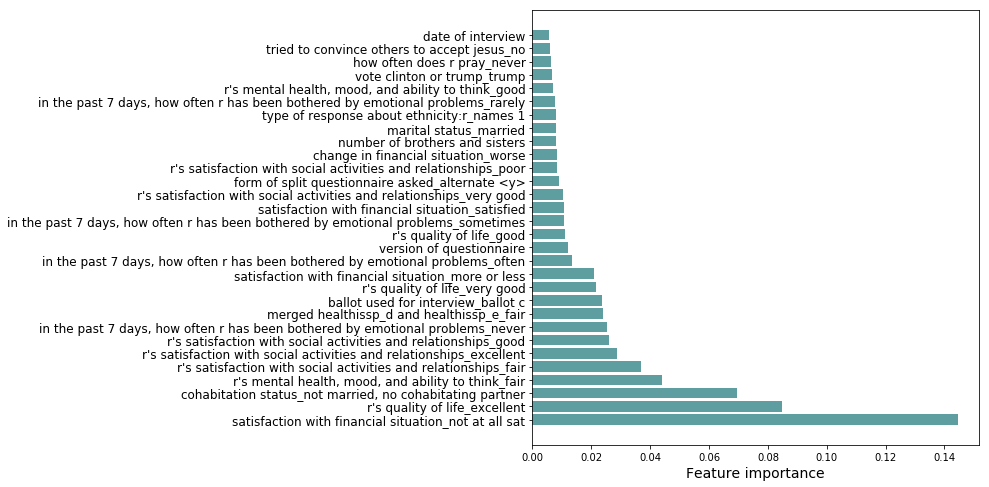

In [353]:
# Extract best performing model from the pipeline 
gbt_all = pipelines_all[3].steps[0][1]
print(gbt_all)

# Feature importances 
plt.figure(figsize=(8,8))
gbt_all_feat_imp = plot_feature_importances(one_hot_df_all, gbt_all, num=30, return_list=True)

In [352]:
len(gbt_all.feature_importances_)

512

In [277]:
gbt_all_feat_imp

[('satfin_3.0', 0.14445331806960324),
 ('quallife_1.0', 0.08463119427535912),
 ('marcohab_3', 0.06941976834847412),
 ('hlthmntl_4.0', 0.04389983948107071),
 ('satsoc_4.0', 0.03697057788965293),
 ('satsoc_1.0', 0.0286520744214609),
 ('satsoc_3.0', 0.0259296835521363),
 ('emoprobs_1.0', 0.025350589394978855),
 ('healthissp_4.0', 0.02390094905579642),
 ('ballot_3', 0.023703361053202726),
 ('quallife_2.0', 0.021734366596851646),
 ('satfin_2.0', 0.020803669767498374),
 ('emoprobs_4.0', 0.01343054157533334),
 ('version', 0.012010378341530493),
 ('quallife_3.0', 0.011134084584047252),
 ('emoprobs_3.0', 0.010873660046458426),
 ('satfin_1.0', 0.010640867633231636),
 ('satsoc_2.0', 0.010532957376941082),
 ('form_2', 0.00903506882451831),
 ('satsoc_5.0', 0.008251412874418135),
 ('finalter_2.0', 0.008203859628062226),
 ('sibs', 0.008027084402281129),
 ('marital_1.0', 0.007973124080230319),
 ('ethnum_1.0', 0.007917319310156752),
 ('emoprobs_2.0', 0.007602296341103862),
 ('hlthmntl_3.0', 0.007101744

In [309]:
# Identify features not included in the list selected by correlation
for i in gbt_all_feat_imp:
    if i[0] not in features + features_add:
        splitted = i[0].split('_')[0]
        if splitted not in features + features_add:
            print(splitted,':', meta_dict[splitted])

ballot : ballot used for interview
version : version of questionnaire
form : form of split questionnaire asked
ethnum : type of response about ethnicity:r
pres16 : vote clinton or trump
pray : how often does r pray
savesoul : tried to convince others to accept jesus
dateintv : date of interview


In [284]:
data_dict('ethnum')

----------------------
ETHNUM
----------------------
Description:        type of response about ethnicity:r
Observations:       2340                
Missing Values:     8                   

Responses:
names 1            0.460256
chooses 1 of 2+    0.322650
cannot choose 1    0.092308
cannot name any    0.124786
UNCODEABLE              NaN
Name: ethnum, dtype: float64


In [285]:
data_dict('ballot')

----------------------
BALLOT
----------------------
Description:        ballot used for interview
Observations:       2348                
Missing Values:     0                   

Responses:
ballot a    0.334327
ballot b    0.329642
ballot c    0.336031
ballot d         NaN
IAP              NaN
Name: ballot, dtype: float64


It is interesting to see how features not directly related to the respondent (such as ballot, version, form, and dateinv) have high feature importances. One possibility is that different versions of the questionnaire might include different number of questions that could explain the respondent's happiness.

Although these features might improve the overall model performance, it wouldn't be as applicable if the final model were continued to be updated with new data.

Otherwise, the other features could be added to the model.

In [40]:
features_add2 = ['ethnum', 'pres16', 'pray', 'savesoul']

#### All features for extreme categories

In [286]:
# oversampled data, all features for extreme categories
pipe_tree_bi = Pipeline([('clf', DecisionTreeClassifier(random_state=123))])
pipe_forest_bi = Pipeline([('clf', RandomForestClassifier(random_state=123))])
pipe_adaboost_bi = Pipeline([('clf', AdaBoostClassifier(random_state=123))])
pipe_gbt_bi = Pipeline([('clf', GradientBoostingClassifier(random_state=123))])
pipe_xgb_bi = Pipeline([('clf', XGB.XGBClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines_bi = [pipe_tree_bi, pipe_forest_bi, pipe_adaboost_bi, pipe_gbt_bi, pipe_xgb_bi]

# Loop to fit each of the three pipelines
# for pipe in pipelines_bi:
#     print(pipe)
#     pipe.fit(X_train_resampled_bi, y_train_resampled_bi)

Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
        

In [287]:
# save the model to disk

# filename = 'smote_vanilla_all_features_bi_pipelines.sav'
# pickle.dump(pipelines_bi, open(filename, 'wb'))
# pipelines_bi = pickle.load(open(filename, 'rb'))

In [288]:
# Compare accuracies & f1 score
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
for index, val in enumerate(pipelines_bi):
    print('%s : %.3f' % (pipeline_names[index], val.score(X_test_scaled_bi, y_test_bi)))
    
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
for index, val in enumerate(pipelines_bi):
    print('%s : %.3f' % (pipeline_names[index],
                         f1_score(y_test_bi, val.predict(X_test_scaled_bi), average='weighted')))

----------------------------------------
Accuracy
----------------------------------------
Decision Tree : 0.787
Random Forest : 0.830
Adaboost : 0.819
Gradient Boosting : 0.840
XGBoost : 0.851

----------------------------------------
Weighted F1 Score
----------------------------------------
Decision Tree : 0.787
Random Forest : 0.824
Adaboost : 0.819
Gradient Boosting : 0.840
XGBoost : 0.849


Model performance improved significantlly by focusing on the two minority classes. XGBoost is the best performing vanilla model for minority classes.

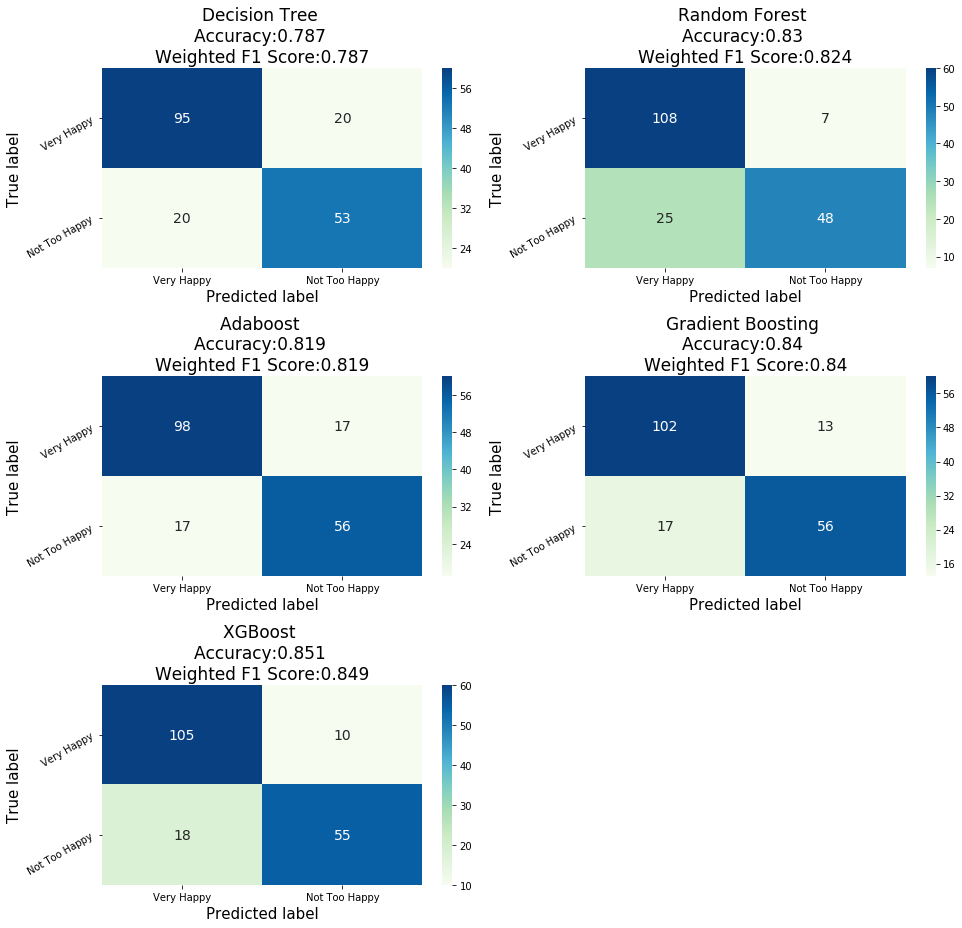

In [289]:
# confusion matrix
fig, ax = plt.subplots(3, 2, figsize=(14,13))
for index, val in enumerate(pipelines_bi):
    plt.subplot(3,2,index+1)
    plot_cm(y_test_bi, val.predict(X_test_scaled_bi), pipeline_names[index], target_classes=2)
    
fig.tight_layout()
fig.delaxes(ax[-1,-1])
plt.show()

In [291]:
for index, val in enumerate(pipelines_bi):
    print('----------------------------------------')
    print(pipeline_names[index])
    print('----------------------------------------')
    print(classification_report(y_test_bi, val.predict(X_test_scaled_bi)))

----------------------------------------
Decision Tree
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.83      0.83      0.83       115
         3.0       0.73      0.73      0.73        73

    accuracy                           0.79       188
   macro avg       0.78      0.78      0.78       188
weighted avg       0.79      0.79      0.79       188

----------------------------------------
Random Forest
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.81      0.94      0.87       115
         3.0       0.87      0.66      0.75        73

    accuracy                           0.83       188
   macro avg       0.84      0.80      0.81       188
weighted avg       0.84      0.83      0.82       188

----------------------------------------
Adaboost
----------------------------------------
              precision    recall  f1-score   support

        

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


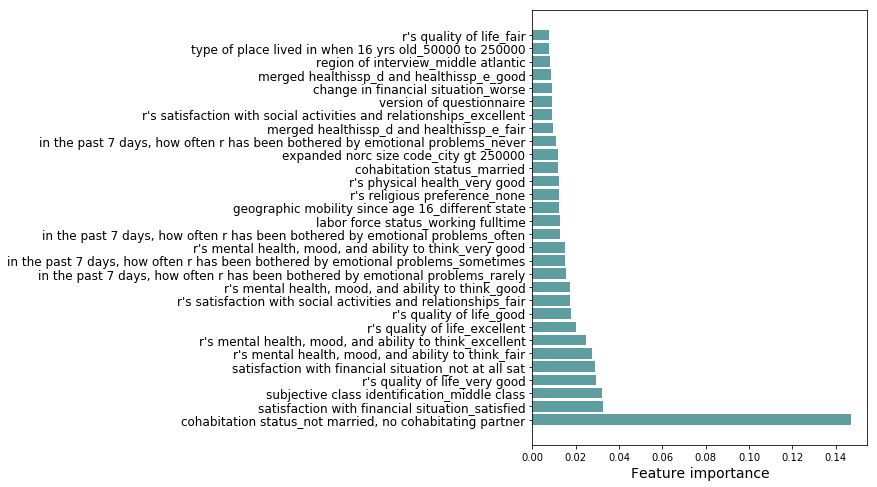

In [293]:
# Extract best performing model from the pipeline 
xgb_bi = pipelines_bi[-1].steps[0][1]
print(xgb_bi)

# Feature importances 
plt.figure(figsize=(6,8))
xgb_bi_feat_imp = plot_feature_importances(one_hot_df_bi, xgb_bi, num=30, return_list=True)

In [354]:
len(xgb_bi.feature_importances_)

493

In [312]:
xgb_bi_feat_imp

[('marcohab_3', 0.14721249),
 ('satfin_1.0', 0.03267352),
 ('class_3.0', 0.032240137),
 ('quallife_2.0', 0.029263217),
 ('satfin_3.0', 0.028798712),
 ('hlthmntl_4.0', 0.027534818),
 ('hlthmntl_1.0', 0.024737429),
 ('quallife_1.0', 0.019887071),
 ('quallife_3.0', 0.017571177),
 ('satsoc_4.0', 0.017559856),
 ('hlthmntl_3.0', 0.017219098),
 ('emoprobs_2.0', 0.015367375),
 ('emoprobs_3.0', 0.015187226),
 ('hlthmntl_2.0', 0.014913344),
 ('emoprobs_4.0', 0.01276984),
 ('wrkstat_1.0', 0.012698324),
 ('mobile16_3', 0.012467473),
 ('relig_4.0', 0.012343284),
 ('hlthphys_2.0', 0.012170769),
 ('marcohab_1', 0.011841814),
 ('xnorcsiz_1', 0.011719892),
 ('emoprobs_1.0', 0.0108680595),
 ('healthissp_4.0', 0.009478439),
 ('satsoc_1.0', 0.009252756),
 ('version', 0.009096622),
 ('finalter_2.0', 0.008980303),
 ('healthissp_3.0', 0.008354918),
 ('region_2', 0.007949909),
 ('res16_4', 0.007732902),
 ('quallife_4.0', 0.007611905)]

In [311]:
# Identify features not included in the list selected by correlation
for i in xgb_bi_feat_imp:
    if i[0] not in features + features_add:
        splitted = i[0].split('_')[0]
        if splitted not in features + features_add:
            print(splitted,':', meta_dict[splitted])

mobile16 : geographic mobility since age 16
version : version of questionnaire


In [314]:
data_dict('mobile16')

----------------------
MOBILE16
----------------------
Description:        geographic mobility since age 16
Observations:       2348                
Missing Values:     0                   

Responses:
same city           0.374787
same st,dif city    0.263203
different state     0.362010
DK                       NaN
IAP                      NaN
NA                       NaN
Name: mobile16, dtype: float64


In [41]:
# Append additionally identified important feature
features_add2.append('mobile16')
print(features_add2)

['ethnum', 'pres16', 'pray', 'savesoul', 'mobile16']


#### Prepare dataset -- Features selected by correlation

In [57]:
# Update clean dataframe for the model (features selected by correlation)
# with 5 additional features
df_cln = df[features+features_add + features_add2 + ['happy']].dropna()
print(len(df_cln))
df_cln.head()

2215


,ratepain,earnrs,educ,hompop,childs,adults,size,cohort,age,sibs,...,parborn,region,xnorcsiz,relig,ethnum,pres16,pray,savesoul,mobile16,happy
0,1.0,1.0,14.0,5,0.0,5.0,14,1975.0,43.0,4.0,...,0.0,1,6,11.0,3.0,2,3.0,1.0,3,2.0
1,7.0,1.0,10.0,2,3.0,2.0,14,1944.0,74.0,4.0,...,1.0,1,6,2.0,1.0,2,2.0,1.0,3,1.0
2,2.0,2.0,16.0,4,2.0,2.0,14,1976.0,42.0,2.0,...,2.0,1,6,4.0,3.0,2,5.0,2.0,3,1.0
3,2.0,2.0,16.0,2,2.0,2.0,14,1955.0,63.0,3.0,...,0.0,1,6,1.0,2.0,8,1.0,1.0,3,1.0
4,0.0,1.0,18.0,2,0.0,2.0,14,1947.0,71.0,3.0,...,2.0,1,6,2.0,2.0,2,2.0,1.0,3,2.0


In [58]:
# features that are categorical variables
features_cat = []
for x in features:
    if x in cat_var:
        features_cat.append(x)
    elif x in codes:
        features_cat.append(x)

for x in features_add:
    if x in cat_var:
        features_cat.append(x)
    elif x in codes:
        features_cat.append(x)

for x in features_add2:
    if x in cat_var:
        features_cat.append(x)
    elif x in codes:
        features_cat.append(x)

print(features_cat)

['quallife', 'satsoc', 'hlthmntl', 'marcohab', 'emoprobs', 'satfin', 'hhtype', 'hlthphys', 'marital', 'healthissp', 'actssoc', 'hhtype1', 'sampcode', 'finalter', 'rplace', 'class', 'incuspop', 'wrkstat', 'dwelling', 'dwellpre', 'degree', 'sex', 'race', 'res16', 'reg16', 'born', 'parborn', 'region', 'xnorcsiz', 'relig', 'ethnum', 'pres16', 'pray', 'savesoul', 'mobile16']


In [59]:
# One-hot encode the categorical features
one_hot_df = pd.get_dummies(df_cln, columns=features_cat)

target = one_hot_df['happy']
one_hot_df.drop('happy', axis=1, inplace=True)

print(one_hot_df.columns)
one_hot_df.head()

Index(['ratepain', 'earnrs', 'educ', 'hompop', 'childs', 'adults', 'size',
       'cohort', 'age', 'sibs',
       ...
       'pray_2.0', 'pray_3.0', 'pray_4.0', 'pray_5.0', 'pray_6.0',
       'savesoul_1.0', 'savesoul_2.0', 'mobile16_1', 'mobile16_2',
       'mobile16_3'],
      dtype='object', length=322)


,ratepain,earnrs,educ,hompop,childs,adults,size,cohort,age,sibs,...,pray_2.0,pray_3.0,pray_4.0,pray_5.0,pray_6.0,savesoul_1.0,savesoul_2.0,mobile16_1,mobile16_2,mobile16_3
0,1.0,1.0,14.0,5,0.0,5.0,14,1975.0,43.0,4.0,...,0,1,0,0,0,1,0,0,0,1
1,7.0,1.0,10.0,2,3.0,2.0,14,1944.0,74.0,4.0,...,1,0,0,0,0,1,0,0,0,1
2,2.0,2.0,16.0,4,2.0,2.0,14,1976.0,42.0,2.0,...,0,0,0,1,0,0,1,0,0,1
3,2.0,2.0,16.0,2,2.0,2.0,14,1955.0,63.0,3.0,...,0,0,0,0,0,1,0,0,0,1
4,0.0,1.0,18.0,2,0.0,2.0,14,1947.0,71.0,3.0,...,1,0,0,0,0,1,0,0,0,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_df, target, test_size=0.2,
                                                    random_state=123)

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train) 

# Convert into a DataFrame
# scaled_df_train = pd.DataFrame(X_train_scaled, columns=features)

# Original class distribution
print('Original class distribution: \n')
print(target.value_counts())

# Synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

2.0    1238
1.0     666
3.0     311
Name: happy, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

3.0    990
2.0    990
1.0    990
Name: happy, dtype: int64


#### Features selected by correlation

In [322]:
# oversampled data, features selected by correlation
pipe_tree = Pipeline([('clf', DecisionTreeClassifier(random_state=123))])
pipe_forest = Pipeline([('clf', RandomForestClassifier(random_state=123))])
pipe_adaboost = Pipeline([('clf', AdaBoostClassifier(random_state=123))])
pipe_gbt = Pipeline([('clf', GradientBoostingClassifier(random_state=123))])
pipe_xgb = Pipeline([('clf', XGB.XGBClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_tree, pipe_forest, pipe_adaboost, pipe_gbt, pipe_xgb]

# Loop to fit each of the three pipelines
# for pipe in pipelines:
#     print(pipe)
#     pipe.fit(X_train_resampled, y_train_resampled)

Pipeline(memory=None,
         steps=[('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
        

In [323]:
# save the model to disk & load the model

# filename = 'smote_vanilla_corr_features_pipelines.sav'
# pickle.dump(pipelines, open(filename, 'wb'))
# pipelines = pickle.load(open(filename, 'rb'))

In [327]:
# Compare accuracies & f1 score
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
for index, val in enumerate(pipelines):
    print('%s : %.3f' % (pipeline_names[index], val.score(X_test_scaled, y_test)))
    
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
for index, val in enumerate(pipelines):
    print('%s : %.3f' % (pipeline_names[index],
                         f1_score(y_test, val.predict(X_test_scaled), average='weighted')))


----------------------------------------
Accuracy
----------------------------------------
Decision Tree : 0.544
Random Forest : 0.648
Adaboost : 0.580
Gradient Boosting : 0.614
XGBoost : 0.632

----------------------------------------
Weighted F1 Score
----------------------------------------
Decision Tree : 0.548
Random Forest : 0.621
Adaboost : 0.580
Gradient Boosting : 0.601
XGBoost : 0.616


The model performance slightly improved compared to those with all features. Random Forest is the best performing vanilla model.

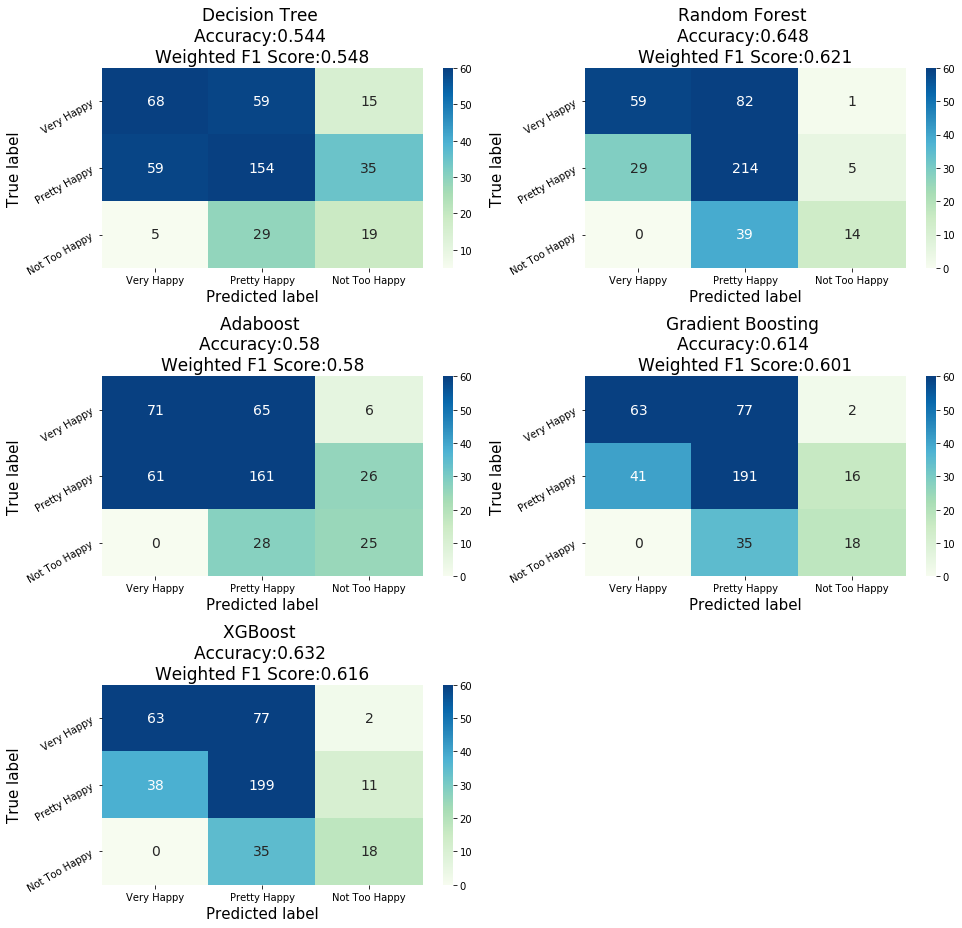

In [328]:
# confusion matrix
fig, ax = plt.subplots(3, 2, figsize=(14,13))
for index, val in enumerate(pipelines):
    plt.subplot(3,2,index+1)
    plot_cm(y_test, val.predict(X_test_scaled), pipeline_names[index])
    
fig.tight_layout()
fig.delaxes(ax[-1,-1])
plt.show()

In [329]:
for index, val in enumerate(pipelines):
    print('----------------------------------------')
    print(pipeline_names[index])
    print('----------------------------------------')
    print(classification_report(y_test, val.predict(X_test_scaled)))

----------------------------------------
Decision Tree
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.52      0.48      0.50       142
         2.0       0.64      0.62      0.63       248
         3.0       0.28      0.36      0.31        53

    accuracy                           0.54       443
   macro avg       0.48      0.49      0.48       443
weighted avg       0.55      0.54      0.55       443

----------------------------------------
Random Forest
----------------------------------------
              precision    recall  f1-score   support

         1.0       0.67      0.42      0.51       142
         2.0       0.64      0.86      0.73       248
         3.0       0.70      0.26      0.38        53

    accuracy                           0.65       443
   macro avg       0.67      0.51      0.54       443
weighted avg       0.66      0.65      0.62       443

----------------------------------------
Adabo

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


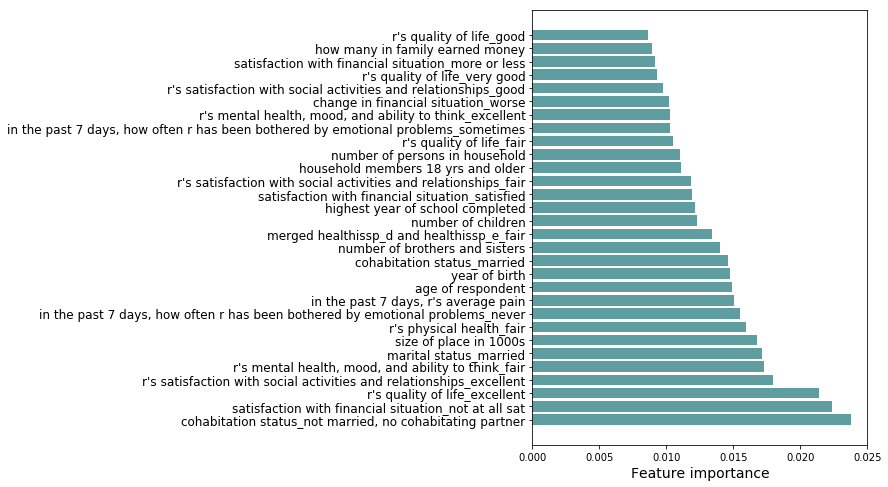

In [340]:
# Extract best performing model from the pipeline 
rf = pipelines[1].steps[0][1]
print(rf)

# Feature importances 
plt.figure(figsize=(6,8))
rf_feat_imp = plot_feature_importances(one_hot_df, rf, num=30, return_list=True)

In [355]:
len(rf.feature_importances_)

322

In [341]:
rf_feat_imp

[('marcohab_3', 0.023817770398315626),
 ('satfin_3.0', 0.02241101096541728),
 ('quallife_1.0', 0.02143999989072175),
 ('satsoc_1.0', 0.017999644270485466),
 ('hlthmntl_4.0', 0.017275755073109446),
 ('marital_1.0', 0.017125678303739702),
 ('size', 0.016766204917124085),
 ('hlthphys_4.0', 0.015926255760224675),
 ('emoprobs_1.0', 0.015536187672218225),
 ('ratepain', 0.015079920714681418),
 ('age', 0.014898285223033087),
 ('cohort', 0.01477016535191077),
 ('marcohab_1', 0.014633570022554101),
 ('sibs', 0.014020614869958656),
 ('healthissp_4.0', 0.013374851195191878),
 ('childs', 0.012282225677200767),
 ('educ', 0.012148682371130894),
 ('satfin_1.0', 0.011917417496516767),
 ('satsoc_4.0', 0.011854725628235188),
 ('adults', 0.011117300423562801),
 ('hompop', 0.011020967309990708),
 ('quallife_4.0', 0.010518101331671867),
 ('emoprobs_3.0', 0.010240898398916023),
 ('hlthmntl_1.0', 0.010239812184007569),
 ('finalter_2.0', 0.010191390280835351),
 ('satsoc_3.0', 0.00977393797679302),
 ('quallife_

In [122]:
for index, val in enumerate(pipelines):
    print('---------------------------')
    print(pipeline_names[index])
    print(classification_report(y_test, val.predict(X_test_scaled)))

---------------------------
Decision Tree
              precision    recall  f1-score   support

         1.0       0.50      0.51      0.50       128
         2.0       0.66      0.66      0.66       261
         3.0       0.18      0.17      0.18        58

    accuracy                           0.55       447
   macro avg       0.45      0.45      0.45       447
weighted avg       0.55      0.55      0.55       447

---------------------------
Random Forest
              precision    recall  f1-score   support

         1.0       0.69      0.51      0.59       128
         2.0       0.68      0.85      0.76       261
         3.0       0.38      0.19      0.25        58

    accuracy                           0.66       447
   macro avg       0.58      0.51      0.53       447
weighted avg       0.65      0.66      0.64       447

---------------------------
Adaboost
              precision    recall  f1-score   support

         1.0       0.58      0.69      0.63       128
        

## GridSearchCV

#### All features for extreme categories

In [370]:
# 1. Fix learning rate and number of estimators for tuning tree-based parameters
bi_param1 = {
    'clf__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'clf__n_estimators': [30, 70, 50, 100, 500],
    'clf__max_depth': [5],
    'clf__min_child_weight' : [1],
    'clf__gamma': [0],
    'clf__subsample': [0.8],
    'clf__colsample_by_tree' : [0.8],
    'clf__scale_pos_weight': [1],
}

# gs_bi1 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param1,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi1.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs1.sav'
# pickle.dump(gs_bi1, open(filename, 'wb'))
# gs_bi1 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished


In [381]:
# pd.DataFrame(gs_bi1.cv_results_)
print(gs_bi1.best_score_)
gs_bi1.best_params_

0.8843023788566826


{'clf__colsample_by_tree': 0.8,
 'clf__gamma': 0,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 5,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [383]:
# 2. Tune max_depth and min_child_weight
bi_param2 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': range(3,10,2),
    'clf__min_child_weight' : range(1,6,2),
    'clf__gamma': [0],
    'clf__subsample': [0.8],
    'clf__colsample_by_tree' : [0.8],
    'clf__scale_pos_weight': [1],
}

# gs_bi2 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param2,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi2.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs2.sav'
# pickle.dump(gs_bi2, open(filename, 'wb'))
# gs_bi2 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


In [384]:
# pd.DataFrame(gs_bi2.cv_results_)
print(gs_bi2.best_score_)
gs_bi2.best_params_

0.8843023788566826


{'clf__colsample_by_tree': 0.8,
 'clf__gamma': 0,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 5,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [386]:
# 3. Further tune max_depth and min_child_weight
bi_param3 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': [4,5,6],
    'clf__min_child_weight' : [1,2],
    'clf__gamma': [0],
    'clf__subsample': [0.8],
    'clf__colsample_by_tree' : [0.8],
    'clf__scale_pos_weight': [1],
}

# gs_bi3 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param3,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi3.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs3.sav'
# pickle.dump(gs_bi3, open(filename, 'wb'))
# gs_bi3 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.3s finished


In [387]:
# pd.DataFrame(gs_bi3.cv_results_)
print(gs_bi3.best_score_)
gs_bi3.best_params_

0.887062504257474


{'clf__colsample_by_tree': 0.8,
 'clf__gamma': 0,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [388]:
# 4. Tune gamma - specifying minimum loss reduction required to make a split.
bi_param4 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': [4],
    'clf__min_child_weight' : [1],
    'clf__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'clf__subsample': [0.8],
    'clf__colsample_by_tree' : [0.8],
    'clf__scale_pos_weight': [1],
}

# gs_bi4 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param4,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi4.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs4.sav'
# pickle.dump(gs_bi4, open(filename, 'wb'))
# gs_bi4 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   40.7s finished


In [389]:
# pd.DataFrame(gs_bi4.cv_results_)
print(gs_bi4.best_score_)
gs_bi4.best_params_

0.8939853143656558


{'clf__colsample_by_tree': 0.8,
 'clf__gamma': 0.3,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [390]:
# 5. Tune subsample and colsample_bytree
bi_param5 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': [4],
    'clf__min_child_weight' : [1],
    'clf__gamma': [0.3],
    'clf__subsample': [0.6, 0.7, 0.8, 0.9],
    'clf__colsample_by_tree' : [0.6, 0.7, 0.8, 0.9],
    'clf__scale_pos_weight': [1],
}

# gs_bi5 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param5,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi5.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs5.sav'
# pickle.dump(gs_bi5, open(filename, 'wb'))
# gs_bi5 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


In [391]:
# pd.DataFrame(gs_bi5.cv_results_)
print(gs_bi5.best_score_)
gs_bi5.best_params_

0.8939853143656558


{'clf__colsample_by_tree': 0.6,
 'clf__gamma': 0.3,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [393]:
# 6. Further tune subsample and colsample_bytree
bi_param6 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': [4],
    'clf__min_child_weight' : [1],
    'clf__gamma': [0.3],
    'clf__subsample': [0.75, 0.8, 0.85],
    'clf__colsample_by_tree' : [0.55, 0.6, 0.65],
    'clf__scale_pos_weight': [1],
}

# gs_bi6 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param6,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi6.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs6.sav'
# pickle.dump(gs_bi6, open(filename, 'wb'))
# gs_bi6 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


In [394]:
# pd.DataFrame(gs_bi6.cv_results_)
print(gs_bi6.best_score_)
gs_bi6.best_params_

0.8939853143656558


{'clf__colsample_by_tree': 0.55,
 'clf__gamma': 0.3,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [396]:
# 7. Tune regularization parameters to reduce overfitting
bi_param7 = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [70],
    'clf__max_depth': [4],
    'clf__min_child_weight' : [1],
    'clf__gamma': [0.3],
    'clf__subsample': [0.8],
    'clf__colsample_by_tree' : [0.55],
    'clf__scale_pos_weight': [1],
    'clf__reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

# gs_bi7 = GridSearchCV(estimator = pipe_xgb_bi,
#                       param_grid = bi_param7,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_bi7.fit(X_train_resampled_bi, y_train_resampled_bi)

# save model
# filename = 'smote_all_features_bi_xgb_gs7.sav'
# pickle.dump(gs_bi7, open(filename, 'wb'))
# gs_bi7 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   34.7s finished


In [397]:
# pd.DataFrame(gs_bi7.cv_results_)
print(gs_bi7.best_score_)
gs_bi7.best_params_

0.8939853143656558


{'clf__colsample_by_tree': 0.55,
 'clf__gamma': 0.3,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 70,
 'clf__reg_alpha': 1e-05,
 'clf__scale_pos_weight': 1,
 'clf__subsample': 0.8}

In [82]:
# Final XGB model with optimal hyperparameters
xgb_bi_final = XGB.XGBClassifier(learning_rate = 0.1,
                                 n_estimators = 70,
                                 max_depth = 4,
                                 min_child_weight = 1,
                                 gamma = 0.3,
                                 subsample = 0.8,
                                 colsample_bytree = 0.55,
                                 reg_alpha = 1e-05,
                                 scale_pos_weight = 1,
                                 random_state=123)

xgb_bi_final.fit(X_train_resampled_bi, y_train_resampled_bi)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

              precision    recall  f1-score   support

         1.0       0.88      0.93      0.91       115
         3.0       0.88      0.81      0.84        73

    accuracy                           0.88       188
   macro avg       0.88      0.87      0.87       188
weighted avg       0.88      0.88      0.88       188



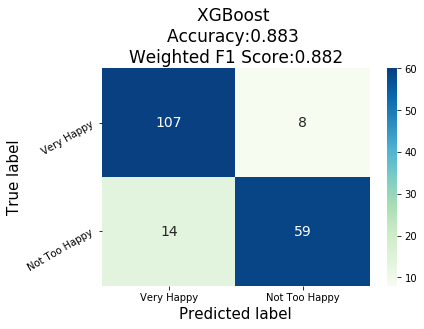

In [83]:
xgb_bi_final_pred = xgb_bi_final.predict(X_test_scaled_bi)

print(classification_report(y_test_bi, xgb_bi_final_pred))
plot_cm(y_test_bi, xgb_bi_final_pred, 'XGBoost', target_classes=2)

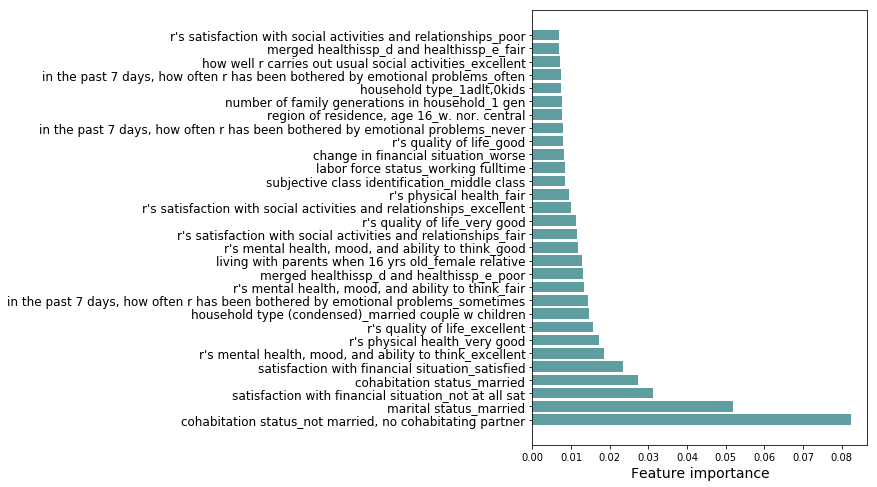

In [409]:
plt.figure(figsize=(6,8))
xgb_bi_final_feat_imp = plot_feature_importances(one_hot_df_bi, 
                                                 xgb_bi_final, num=30, return_list=True)

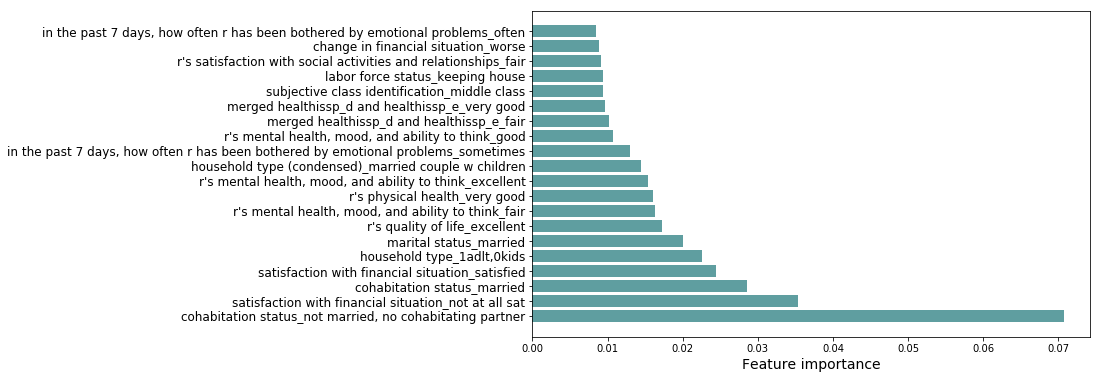

In [84]:
plt.figure(figsize=(10,6))
xgb_bi_final_feat_imp = plot_feature_importances(one_hot_df_bi, xgb_bi_final, num=20)

In [410]:
xgb_bi_final_feat_imp

[('marcohab_3', 0.08250414),
 ('marital_1.0', 0.05184191),
 ('satfin_3.0', 0.031143624),
 ('marcohab_1', 0.02737005),
 ('satfin_1.0', 0.023418376),
 ('hlthmntl_1.0', 0.018453442),
 ('hlthphys_2.0', 0.017180622),
 ('quallife_1.0', 0.015754016),
 ('hhtype1_11.0', 0.014546561),
 ('emoprobs_3.0', 0.014455379),
 ('hlthmntl_4.0', 0.013355372),
 ('healthissp_5.0', 0.013092556),
 ('family16_7.0', 0.012859399),
 ('hlthmntl_3.0', 0.0118013285),
 ('satsoc_4.0', 0.011514406),
 ('quallife_2.0', 0.011252453),
 ('satsoc_1.0', 0.010022731),
 ('hlthphys_4.0', 0.009560968),
 ('class_3.0', 0.008447204),
 ('wrkstat_1.0', 0.008307928),
 ('finalter_2.0', 0.008240807),
 ('quallife_3.0', 0.007984522),
 ('emoprobs_1.0', 0.0079506235),
 ('reg16_4', 0.0077650975),
 ('famgen_1', 0.0077335155),
 ('hhtype_1.0', 0.0072917473),
 ('emoprobs_4.0', 0.007289762),
 ('actssoc_1.0', 0.007092126),
 ('healthissp_4.0', 0.0069894204),
 ('satsoc_5.0', 0.0068199346)]

#### Features selected by correlation

In [413]:
pipe_forest

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [411]:
# 1. Initial grid search of the parameters
corr_param1 = {
    'clf__criterion': ["gini", "entropy"],
    'clf__n_estimators': [50, 100, 200, 300], 
    'clf__max_features': ['auto', 'sqrt', 0.2],
    'clf__min_samples_leaf': [1,5,10,50,100]
}

# gs_corr1 = GridSearchCV(estimator = pipe_forest,
#                       param_grid = corr_param1,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_corr1.fit(X_train_resampled, y_train_resampled)

# save model
# filename = 'smote_corr_features_rf_gs1.sav'
# pickle.dump(gs_corr1, open(filename, 'wb'))
# gs_corr1 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.7min finished


In [412]:
# pd.DataFrame(gs_corr1.cv_results_)
print(gs_corr1.best_score_)
gs_corr1.best_params_

0.7771727413874162


{'clf__criterion': 'gini',
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__n_estimators': 300}

In [414]:
# 2. Further tune n_estimators and min_samples_leaf
corr_param2 = {
    'clf__criterion': ["gini"],
    'clf__n_estimators': [250, 300, 350, 500], 
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [1,2,3,4]
}

# gs_corr2 = GridSearchCV(estimator = pipe_forest,
#                       param_grid = corr_param2,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_corr2.fit(X_train_resampled, y_train_resampled)

# save model
# filename = 'smote_corr_features_rf_gs2.sav'
# pickle.dump(gs_corr2, open(filename, 'wb'))
# gs_corr2 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished


In [415]:
# pd.DataFrame(gs_corr2.cv_results_)
print(gs_corr2.best_score_)
gs_corr2.best_params_

0.7802364330331396


{'clf__criterion': 'gini',
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__n_estimators': 500}

In [416]:
# 3. Further tune n_estimators
corr_param3 = {
    'clf__criterion': ["gini"],
    'clf__n_estimators': [400, 500, 700, 1000], 
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [1]
}

# gs_corr3 = GridSearchCV(estimator = pipe_forest,
#                       param_grid = corr_param3,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_corr3.fit(X_train_resampled, y_train_resampled)

# save model
# filename = 'smote_corr_features_rf_gs3.sav'
# pickle.dump(gs_corr3, open(filename, 'wb'))
# gs_corr3 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


In [417]:
# pd.DataFrame(gs_corr3.cv_results_)
print(gs_corr3.best_score_)
gs_corr3.best_params_

0.7808123505678607


{'clf__criterion': 'gini',
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__n_estimators': 400}

In [421]:
# 4. Tune max depth and min_samples_split
corr_param4 = {
    'clf__criterion': ["gini"],
    'clf__n_estimators': [400], 
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [1],
    'clf__max_depth': [None, 3, 5, 7, 9],
    'clf__min_samples_split': range(1,6)
}

# gs_corr4 = GridSearchCV(estimator = pipe_forest,
#                       param_grid = corr_param4,
#                       scoring='f1_weighted',
#                       cv=5, verbose=2, n_jobs=-1,
#                       return_train_score = True)

# gs_corr4.fit(X_train_resampled, y_train_resampled)

# save model
# filename = 'smote_corr_features_rf_gs4.sav'
# pickle.dump(gs_corr4, open(filename, 'wb'))
# gs_corr4 = pickle.load(open(filename, 'rb'))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.8min finished


In [422]:
# pd.DataFrame(gs_corr4.cv_results_)
print(gs_corr4.best_score_)
gs_corr4.best_params_

0.7823370725644987


{'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 3,
 'clf__n_estimators': 400}

In [64]:
# Final random forest model with optimal parameters
rf_corr_final = RandomForestClassifier(criterion='gini',
                                  n_estimators=400,
                                  max_depth=None,
                                  max_features='auto', 
                                  min_samples_leaf=1,
                                  min_samples_split=3,
                                  random_state=123)

rf_corr_final.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

         1.0       0.67      0.41      0.51       142
         2.0       0.63      0.86      0.73       248
         3.0       0.69      0.21      0.32        53

    accuracy                           0.64       443
   macro avg       0.66      0.49      0.52       443
weighted avg       0.65      0.64      0.61       443



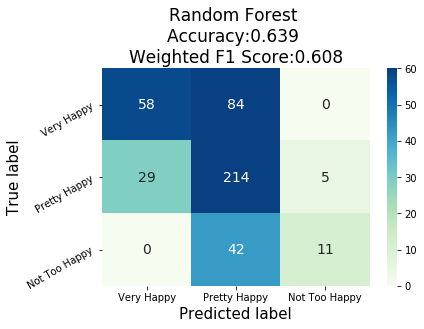

In [65]:
rf_corr_final_pred = rf_corr_final.predict(X_test_scaled)

print(classification_report(y_test, rf_corr_final_pred))
plot_cm(y_test, rf_corr_final_pred, 'Random Forest', target_classes=3)

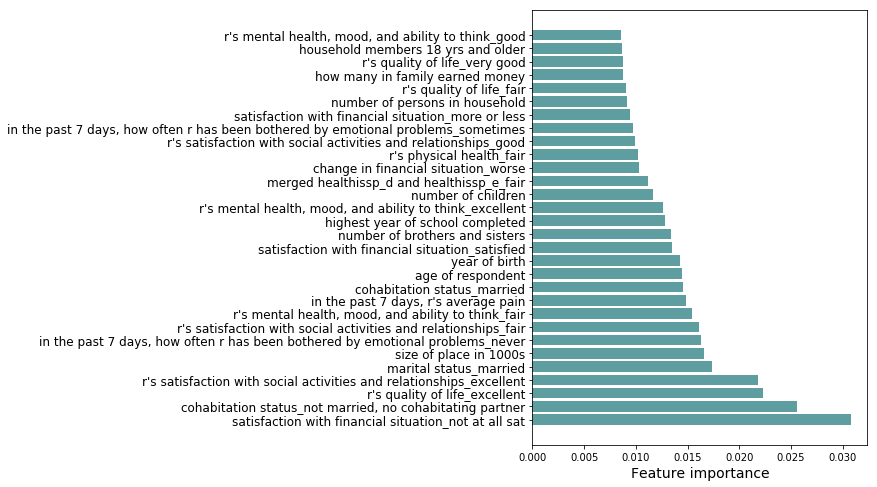

In [66]:
plt.figure(figsize=(6,8))
rf_corr_final_feat_imp = plot_feature_importances(one_hot_df, 
                                                 rf_corr_final, num=30, return_list=True)

In [67]:
rf_corr_final_feat_imp

[('satfin_3.0', 0.030816837910178956),
 ('marcohab_3', 0.02559915965373436),
 ('quallife_1.0', 0.02224128071557934),
 ('satsoc_1.0', 0.021801854504793182),
 ('marital_1.0', 0.01739639196731272),
 ('size', 0.016574427941439984),
 ('emoprobs_1.0', 0.016324225428213122),
 ('satsoc_4.0', 0.016080226481590163),
 ('hlthmntl_4.0', 0.015465383934471914),
 ('ratepain', 0.014877682767893774),
 ('marcohab_1', 0.014597981726733423),
 ('age', 0.014447213476408245),
 ('cohort', 0.014248602097203886),
 ('satfin_1.0', 0.01350936258649208),
 ('sibs', 0.013414493813310271),
 ('educ', 0.01283951193270573),
 ('hlthmntl_1.0', 0.012623472585899182),
 ('childs', 0.011641345820870787),
 ('healthissp_4.0', 0.011201621190925406),
 ('finalter_2.0', 0.010283876877400417),
 ('hlthphys_4.0', 0.01019115968115977),
 ('satsoc_3.0', 0.009950152551670888),
 ('emoprobs_3.0', 0.009744540269484877),
 ('satfin_2.0', 0.009464805196030842),
 ('hompop', 0.009095044966381235),
 ('quallife_4.0', 0.00900802344304881),
 ('earnrs',

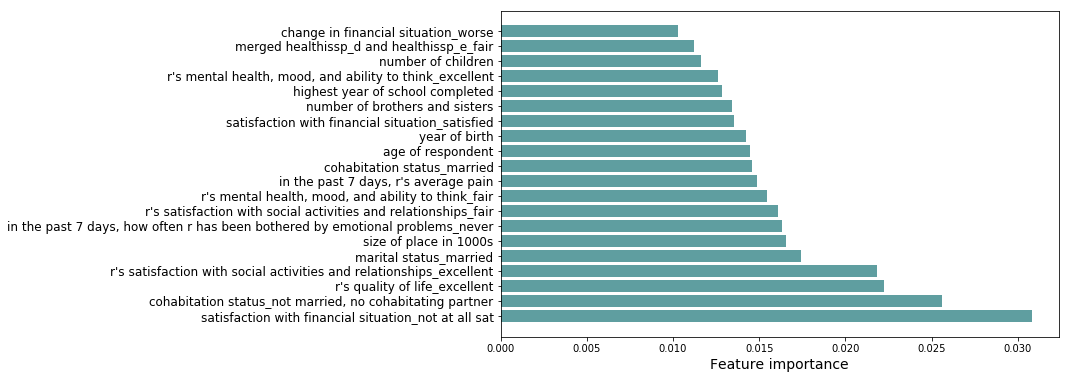

In [69]:
plt.figure(figsize=(10,6))
rf_corr_final_feat_imp = plot_feature_importances(one_hot_df, rf_corr_final, num=20)